In [37]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,export_questionnaire,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
 plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel
from regression_functions import run_regression_with_feature_importance,run_pca_regression_with_feature_importance

In [38]:
SEED = 17
os.environ["PYTHONHASHSEED"] = str(SEED)

# לכבות רנדומליות בספריות BLAS/OMP
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

random.seed(SEED)
np.random.seed(SEED)

print("Seed fixed:", SEED)

Seed fixed: 17


# creating the merged file of the regression parmeters and pc 

In [39]:
import pandas as pd

# -------------------------
# 1. Read your input files
# -------------------------

orig_path = r"data\original_Q_data\5_timepoints\b_questionnaire.csv"     # The file you give with Subject_Code + PC columns
reg_path = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" # File containing Subject_Code + regression variables

orig_path = pd.read_csv(orig_path)
reg_df = pd.read_csv(reg_path)

# -------------------------
# 2. Select desired regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 
    'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal',
    'after_MPAS_total',
    'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 
    'after_MPAS_Interaction',
    't1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Merge PC file with regression columns
# -------------------------

merged = pd.merge(
    orig_path,       # keep all PC columns exactly as they are in your file
    reg_sel, 
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 4. Save result
# -------------------------
print(merged.columns.tolist())
output_path = r"only_Q_outputs\combined\regression\without-pca\merged_before_no_pca_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)




['Unnamed: 0', 'Subject_Code', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total', 'after_DES_Absorption ', 'after_DES_Amnesia', 'after_DES_Depersonalization ', 'after_DERS_total', 'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']
Saved merged file:
 - only_Q_outputs\com

In [40]:
import pandas as pd

# -------------------------
# 1. Read your input files
# -------------------------

orig_path = r"data\original_Q_data\5_timepoints\t1_questionnaire.csv"     # The file you give with Subject_Code + PC columns
reg_path = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" # File containing Subject_Code + regression variables

orig_path = pd.read_csv(orig_path)
reg_df = pd.read_csv(reg_path)

# -------------------------
# 2. Select desired regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 
    'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal',
    'after_MPAS_total',
    'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 
    'after_MPAS_Interaction',
    't1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Merge PC file with regression columns
# -------------------------

merged = pd.merge(
    orig_path,       # keep all PC columns exactly as they are in your file
    reg_sel, 
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 4. Save result
# -------------------------
print(merged.columns.tolist())
output_path = r"only_Q_outputs\combined\regression\without-pca\merged_t1_no_pca_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)




['Unnamed: 0', 'Subject_Code', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total', 'after_DES_Absorption ', 'after_DES_Amnesia', 'after_DES_Depersonalization ', 'after_DERS_total', 'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']
Saved merged file:
 - on

In [41]:
import pandas as pd

# -------------------------
# 1. Read your input files
# -------------------------

orig_path = r"data\original_Q_data\5_timepoints\t2_questionnaire.csv"     # The file you give with Subject_Code + PC columns
reg_path = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" # File containing Subject_Code + regression variables

orig_path = pd.read_csv(orig_path)
reg_df = pd.read_csv(reg_path)

# -------------------------
# 2. Select desired regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 
    'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal',
    'after_MPAS_total',
    'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 
    'after_MPAS_Interaction',
    't1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Merge PC file with regression columns
# -------------------------

merged = pd.merge(
    orig_path,       # keep all PC columns exactly as they are in your file
    reg_sel, 
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 4. Save result
# -------------------------
print(merged.columns.tolist())
output_path = r"only_Q_outputs\combined\regression\without-pca\merged_t2_no_pca_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)




['Unnamed: 0', 'Subject_Code', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total', 'after_DES_Absorption ', 'after_DES_Amnesia', 'after_DES_Depersonalization ', 'after_DERS_total', 'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']
Saved merged file:
 - on

In [42]:
import pandas as pd

# -------------------------
# 1. Read your input files
# -------------------------

orig_path = r"data\original_Q_data\5_timepoints\t3_questionnaire.csv"     # The file you give with Subject_Code + PC columns
reg_path = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" # File containing Subject_Code + regression variables

orig_path = pd.read_csv(orig_path)
reg_df = pd.read_csv(reg_path)

# -------------------------
# 2. Select desired regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 
    'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal',
    'after_MPAS_total',
    'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 
    'after_MPAS_Interaction',
    't1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Merge PC file with regression columns
# -------------------------

merged = pd.merge(
    orig_path,       # keep all PC columns exactly as they are in your file
    reg_sel, 
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 4. Save result
# -------------------------
print(merged.columns.tolist())
output_path = r"only_Q_outputs\combined\regression\without-pca\merged_t3_no_pca_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)




['Unnamed: 0', 'Subject_Code', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7', 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total', 'after_DES_Absorption ', 'after_DES_Amnesia', 'after_DES_Depersonalization ', 'after_DERS_total', 'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']
Saved merged file:
 - on

In [43]:
import pandas as pd

# -------------------------
# 1. Read your input files
# -------------------------

orig_path = r"data\original_Q_data\5_timepoints\after_questionnaire.csv"     # The file you give with Subject_Code + PC columns
reg_path = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" # File containing Subject_Code + regression variables

orig_path = pd.read_csv(orig_path)
reg_df = pd.read_csv(reg_path)

# -------------------------
# 2. Select desired regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 
    'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal',
    'after_MPAS_total',
    'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 
    'after_MPAS_Interaction',
    't1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Merge PC file with regression columns
# -------------------------

merged = pd.merge(
    orig_path,       # keep all PC columns exactly as they are in your file
    reg_sel, 
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 4. Save result
# -------------------------
print(merged.columns.tolist())
output_path = r"only_Q_outputs\combined\regression\without-pca\merged_after_no_pca_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)




['Unnamed: 0', 'Subject_Code', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7', 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total', 'after_DES_Absorption ', 'after_DES_Amnesia', 'after_DES_Depersonalization ', 'after_DERS_total', 'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_L

In [44]:
my_data = pd.read_csv(r"only_Q_outputs\combined\regression\without-pca\merged_before_no_pca_with_regression.csv")

feature_cols = ['b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7']

targets = [ 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 
'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ',
'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 
'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total']

# Create a new directory path for the individual feature files
feature_output_dir = r"only_Q_outputs\combined\regression\without-pca\b_feature_csv"

# Call the updated function
pred_df, results_df = run_regression_with_feature_importance(
    df=my_data,
    feature_cols=feature_cols,
    targets=targets,
    save_csv_path=r"only_Q_outputs\combined\regression\without-pca\summary_csv\regression_feature_importance_b_no_pca.csv",
    save_plots=False,
    # --- NEW ARGUMENT USED HERE ---
    save_target_csv_dir=feature_output_dir
    # ------------------------------
)


📁 Saved feature importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\without-pca\b_feature_csv\after_bits_PTSD_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_total
   Feature: b_PHQ_3              | Coefficient:     1.1672 | Importance:   1.1672
   Feature: b_PHQ_4              | Coefficient:     0.1124 | Importance:   0.1124
   Feature: b_PHQ_5              | Coefficient:     0.5235 | Importance:   0.5235
   Feature: b_PHQ_6              | Coefficient:     1.5445 | Importance:   1.5445
   Feature: b_GAD7_1             | Coefficient:     1.7706 | Importance:   1.7706
   Feature: b_GAD7_2             | Coefficient:     3.8807 | Importance:   3.8807
   Feature: b_GAD7_5             | Coefficient:     3.8407 | Importance:   3.8407
📁 Saved feature importance for Target 'after_bits_birth_symptoms' to: only_Q_outputs\combined\regression\without-pca\b_feature_csv\after_bits_birth_symptoms_feature_importance.csv

✅ Non-Zero Predi

In [45]:
my_data = pd.read_csv(r"only_Q_outputs\combined\regression\without-pca\merged_t1_no_pca_with_regression.csv")

feature_cols = ['t1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7']

targets = [ 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 
'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ',
'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 
'after_MPAS_Interaction', 't1_MAAS_total', 't2_MAAS_total', 't3_MAAS_total']

# Create a new directory path for the individual feature files
feature_output_dir = r"only_Q_outputs\combined\regression\without-pca\t1_feature_csv"

# Call the updated function
pred_df, results_df = run_regression_with_feature_importance(
    df=my_data,
    feature_cols=feature_cols,
    targets=targets,
    save_csv_path=r"only_Q_outputs\combined\regression\without-pca\regression_feature_importance_t1_no_pca.csv",
    save_plots=False,
    # --- NEW ARGUMENT USED HERE ---
    save_target_csv_dir=feature_output_dir
    # ------------------------------
)


📁 Saved feature importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\without-pca\t1_feature_csv\after_bits_PTSD_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_total
   Feature: t1_PHQ_2             | Coefficient:     0.2905 | Importance:   0.2905
   Feature: t1_PHQ_3             | Coefficient:     0.6768 | Importance:   0.6768
   Feature: t1_PHQ_5             | Coefficient:     1.0017 | Importance:   1.0017
   Feature: t1_GAD7_1            | Coefficient:     1.9425 | Importance:   1.9425
   Feature: t1_GAD7_4            | Coefficient:     2.1776 | Importance:   2.1776
   Feature: t1_GAD7_7            | Coefficient:     0.4350 | Importance:   0.4350
📁 Saved feature importance for Target 'after_bits_birth_symptoms' to: only_Q_outputs\combined\regression\without-pca\t1_feature_csv\after_bits_birth_symptoms_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_birth_symptoms
   Feature: t1_PHQ_3             | C

In [46]:
my_data = pd.read_csv(r"only_Q_outputs\combined\regression\without-pca\merged_t2_no_pca_with_regression.csv")

feature_cols = ['t2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7']

targets = [ 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 
'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ',
'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 
'after_MPAS_Interaction', 't2_MAAS_total', 't3_MAAS_total']

# Create a new directory path for the individual feature files
feature_output_dir = r"only_Q_outputs\combined\regression\without-pca\t2_feature_csv"

# Call the updated function
pred_df, results_df = run_regression_with_feature_importance(
    df=my_data,
    feature_cols=feature_cols,
    targets=targets,
    save_csv_path=r"only_Q_outputs\combined\regression\without-pca\summary_csv\regression_feature_importance_t2_no_pca.csv",
    save_plots=False,
    # --- NEW ARGUMENT USED HERE ---
    save_target_csv_dir=feature_output_dir
    # ------------------------------
)


📁 Saved feature importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\without-pca\t2_feature_csv\after_bits_PTSD_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_total
   Feature: t2_PHQ_3             | Coefficient:     0.4415 | Importance:   0.4415
   Feature: t2_PHQ_5             | Coefficient:     1.2242 | Importance:   1.2242
   Feature: t2_PHQ_7             | Coefficient:     1.3946 | Importance:   1.3946
   Feature: t2_GAD7_1            | Coefficient:     2.2144 | Importance:   2.2144
   Feature: t2_GAD7_2            | Coefficient:     0.2024 | Importance:   0.2024
   Feature: t2_GAD7_3            | Coefficient:     0.5239 | Importance:   0.5239
   Feature: t2_GAD7_4            | Coefficient:     0.0134 | Importance:   0.0134
   Feature: t2_GAD7_5            | Coefficient:     1.3630 | Importance:   1.3630
   Feature: t2_GAD7_6            | Coefficient:     0.9178 | Importance:   0.9178
   Feature: t2_GAD7_7           

In [47]:
my_data = pd.read_csv(r"only_Q_outputs\combined\regression\without-pca\merged_t3_no_pca_with_regression.csv")

feature_cols = ['t3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7']

targets = [ 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 
'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ',
'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 
'after_MPAS_Interaction', 't3_MAAS_total']

# Create a new directory path for the individual feature files
feature_output_dir = r"only_Q_outputs\combined\regression\without-pca\t3_feature_csv"

# Call the updated function
pred_df, results_df = run_regression_with_feature_importance(
    df=my_data,
    feature_cols=feature_cols,
    targets=targets,
    save_csv_path=r"only_Q_outputs\combined\regression\without-pca\summary_csv\regression_feature_importance_t3_no_pca.csv",
    save_plots=False,
    # --- NEW ARGUMENT USED HERE ---
    save_target_csv_dir=feature_output_dir
    # ------------------------------
)


📁 Saved feature importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\without-pca\t3_feature_csv\after_bits_PTSD_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_total
   Feature: t3_PHQ_1             | Coefficient:     0.3454 | Importance:   0.3454
   Feature: t3_PHQ_3             | Coefficient:     0.5917 | Importance:   0.5917
   Feature: t3_PHQ_5             | Coefficient:     1.7536 | Importance:   1.7536
   Feature: t3_PHQ_6             | Coefficient:     1.3524 | Importance:   1.3524
   Feature: t3_GAD7_3            | Coefficient:     0.6869 | Importance:   0.6869
   Feature: t3_GAD7_4            | Coefficient:     0.5555 | Importance:   0.5555
   Feature: t3_GAD7_6            | Coefficient:     1.8258 | Importance:   1.8258
   Feature: t3_GAD7_7            | Coefficient:     0.0315 | Importance:   0.0315
📁 Saved feature importance for Target 'after_bits_birth_symptoms' to: only_Q_outputs\combined\regression\without-p

In [48]:
my_data = pd.read_csv(r"only_Q_outputs\combined\regression\without-pca\merged_after_no_pca_with_regression.csv")

feature_cols = ['after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']

targets = [ 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 
'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ',
'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 
'after_MPAS_Interaction']

# Create a new directory path for the individual feature files
feature_output_dir = r"only_Q_outputs\combined\regression\without-pca\after_feature_csv"

# Call the updated function
pred_df, results_df = run_regression_with_feature_importance(
    df=my_data,
    feature_cols=feature_cols,
    targets=targets,
    save_csv_path=r"only_Q_outputs\combined\regression\without-pca\summary_csv\regression_feature_importance_after_no_pca.csv",
    save_plots=False,
    # --- NEW ARGUMENT USED HERE ---
    save_target_csv_dir=feature_output_dir
    # ------------------------------
)


📁 Saved feature importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\without-pca\after_feature_csv\after_bits_PTSD_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_total
   Feature: after_PHQ_1          | Coefficient:     2.6632 | Importance:   2.6632
   Feature: after_PHQ_3          | Coefficient:     1.5454 | Importance:   1.5454
   Feature: after_PHQ_4          | Coefficient:     0.4699 | Importance:   0.4699
   Feature: after_PHQ_5          | Coefficient:     0.8236 | Importance:   0.8236
   Feature: after_PHQ_7          | Coefficient:     0.0127 | Importance:   0.0127
   Feature: after_GAD7_1         | Coefficient:     2.0322 | Importance:   2.0322
   Feature: after_GAD7_3         | Coefficient:     0.2988 | Importance:   0.2988
   Feature: after_GAD7_4         | Coefficient:     1.7700 | Importance:   1.7700
   Feature: after_GAD7_6         | Coefficient:     1.3182 | Importance:   1.3182
📁 Saved feature importance fo

In [49]:
import pandas as pd
import os

# --- Configuration: DataFrames are loaded from the uploaded content ---
# The variables df_b, df_t1, df_t2, df_t3, df_after are assumed to contain the data
# from your previously uploaded files (b_questionnaire.csv, t1_questionnaire.csv, etc.).

# Define the uploaded file contents as DataFrames based on the provided content.
# This assumes the code is running in an environment where these objects are available
# or that you will insert the code to load them from your system if running locally.

# --- Since I cannot access your local file system, I will use the uploaded dataframes directly ---
# Re-mapping the DataFrames based on the uploaded file contents (as they appeared in the context)

# In a real environment, you would use this (which you were attempting):
df_b = pd.read_csv(r"data\original_Q_data\5_timepoints\b_questionnaire.csv")
df_t1 = pd.read_csv(r"data\original_Q_data\5_timepoints\t1_questionnaire.csv")
df_t2 = pd.read_csv(r"data\original_Q_data\5_timepoints\t2_questionnaire.csv")
df_t3 = pd.read_csv(r"data\original_Q_data\5_timepoints\t3_questionnaire.csv")
df_after = pd.read_csv(r"data\original_Q_data\5_timepoints\after_questionnaire.csv")


# --- IMPORTANT: Ensure 'Subject_Code' is in all feature lists for correct merging ---
files_and_features = {
    'df_b': ['Subject_Code', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7'],
    'df_t1': ['Subject_Code', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7'],
    'df_t2': ['Subject_Code', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7'],
    'df_t3': ['Subject_Code', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7'],
    'df_after': ['Subject_Code', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']
}

# Map string keys to the actual DataFrame objects (Assuming these DataFrames are already loaded)
df_map = {
    'df_b': df_b,
    'df_t1': df_t1,
    'df_t2': df_t2,
    'df_t3': df_t3,
    'df_after': df_after
}

# Output file path
output_csv_path = r"only_Q_outputs\combined\regression\without-pca\merged_questionnaire_data_all_timepoints.csv"

# --- Merging Logic ---

print("Starting merge process for questionnaire data by Subject_Code...")

# 1. Initialize the final merged DataFrame with the first file's filtered data
df_keys = list(files_and_features.keys())
first_df_key = df_keys[0]
initial_df = df_map[first_df_key]
initial_cols = files_and_features[first_df_key]
merged_df = initial_df[initial_cols].copy()

# 2. Iterate through the rest of the files and merge them one by one
for df_key in df_keys[1:]:
    columns_to_keep = files_and_features[df_key]
    current_df = df_map[df_key]
    
    # Select only the desired columns (features_to_keep)
    df_to_merge = current_df[columns_to_keep].copy()

    # Perform the merge using 'Subject_Code'
    merged_df = pd.merge(
        merged_df,
        df_to_merge,
        on='Subject_Code',
        how='outer'
    )
    print(f"Successfully merged data from {df_key}. Current shape: {merged_df.shape}")


# 3. Save the final merged CSV
merged_df.to_csv(output_csv_path, index=False)

print("\n--- Process Complete ---")
print(f"Successfully merged all time-point questionnaire data into: {output_csv_path}")
print("\nFirst 5 rows of the merged data:")
print(merged_df.head())

Starting merge process for questionnaire data by Subject_Code...
Successfully merged data from df_t1. Current shape: (170, 33)
Successfully merged data from df_t2. Current shape: (170, 49)
Successfully merged data from df_t3. Current shape: (171, 65)
Successfully merged data from df_after. Current shape: (171, 81)

--- Process Complete ---
Successfully merged all time-point questionnaire data into: only_Q_outputs\combined\regression\without-pca\merged_questionnaire_data_all_timepoints.csv

First 5 rows of the merged data:
  Subject_Code  b_PHQ_1  b_PHQ_2  b_PHQ_3  b_PHQ_4  b_PHQ_5  b_PHQ_6  b_PHQ_7  \
0        CT002      0.0      0.0      1.0      1.0      1.0      0.0      1.0   
1        CT003      0.0      1.0      1.0      2.0      0.0      0.0      0.0   
2        CT004      0.0      0.0      1.0      1.0      0.0      1.0      1.0   
3        CT005      0.0      1.0      3.0      3.0      2.0      0.0      2.0   
4        CT007      1.0      1.0      0.0      1.0      0.0      1.

In [50]:
import pandas as pd

# -------------------------
# 1. Read your input files
# -------------------------

orig_path = r"only_Q_outputs\combined\regression\without-pca\merged_questionnaire_data_all_timepoints.csv"     # The file you give with Subject_Code + PC columns
reg_path = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" # File containing Subject_Code + regression variables

orig_path = pd.read_csv(orig_path)
reg_df = pd.read_csv(reg_path)

# -------------------------
# 2. Select desired regression columns
# -------------------------

regression_cols = [
    "Subject_Code",
    'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 
    'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal',
    'after_MPAS_total',
    'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 
    'after_MPAS_Interaction',
    't1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()

# -------------------------
# 3. Merge PC file with regression columns
# -------------------------

merged = pd.merge(
    orig_path,       # keep all PC columns exactly as they are in your file
    reg_sel, 
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 3b. Remove rows with any NaN value (Complete Case Analysis)
# -------------------------
merged.dropna(inplace=True)
# -------------------------
# 4. Save result
# -------------------------
print(merged.columns.tolist())
output_path = r"only_Q_outputs\combined\regression\without-pca\summary_csv\merged_trajectory_no_pca_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)




['Subject_Code', 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7', 't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7', 't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7', 'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'aft

In [51]:
my_data = pd.read_csv(r"only_Q_outputs\combined\regression\without-pca\merged_trajectory_no_pca_with_regression.csv")

feature_cols = [ 'b_PHQ_1', 'b_PHQ_2', 'b_PHQ_3', 'b_PHQ_4', 'b_PHQ_5', 'b_PHQ_6', 'b_PHQ_7', 'b_PHQ_8', 'b_PHQ_9', 'b_GAD7_1', 'b_GAD7_2', 'b_GAD7_3', 'b_GAD7_4', 'b_GAD7_5', 'b_GAD7_6', 'b_GAD7_7', 
                't1_PHQ_1', 't1_PHQ_2', 't1_PHQ_3', 't1_PHQ_4', 't1_PHQ_5', 't1_PHQ_6', 't1_PHQ_7', 't1_PHQ_8', 't1_PHQ_9', 't1_GAD7_1', 't1_GAD7_2', 't1_GAD7_3', 't1_GAD7_4', 't1_GAD7_5', 't1_GAD7_6', 't1_GAD7_7',
                't2_PHQ_1', 't2_PHQ_2', 't2_PHQ_3', 't2_PHQ_4', 't2_PHQ_5', 't2_PHQ_6', 't2_PHQ_7', 't2_PHQ_8', 't2_PHQ_9', 't2_GAD7_1', 't2_GAD7_2', 't2_GAD7_3', 't2_GAD7_4', 't2_GAD7_5', 't2_GAD7_6', 't2_GAD7_7',
                't3_PHQ_1', 't3_PHQ_2', 't3_PHQ_3', 't3_PHQ_4', 't3_PHQ_5', 't3_PHQ_6', 't3_PHQ_7', 't3_PHQ_8', 't3_PHQ_9', 't3_GAD7_1', 't3_GAD7_2', 't3_GAD7_3', 't3_GAD7_4', 't3_GAD7_5', 't3_GAD7_6', 't3_GAD7_7',
                'after_PHQ_1', 'after_PHQ_2', 'after_PHQ_3', 'after_PHQ_4', 'after_PHQ_5', 'after_PHQ_6', 'after_PHQ_7', 'after_PHQ_8', 'after_PHQ_9', 'after_GAD7_1', 'after_GAD7_2', 'after_GAD7_3', 'after_GAD7_4', 'after_GAD7_5', 'after_GAD7_6', 'after_GAD7_7']



targets = [ 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion', 
'after_bits_Re_experiencing ', 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ',
'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 'after_MPAS_Hostility', 
'after_MPAS_Interaction']

# Create a new directory path for the individual feature files
feature_output_dir = r"only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv"

# Call the updated function
pred_df, results_df = run_regression_with_feature_importance(
    df=my_data,
    feature_cols=feature_cols,
    targets=targets,
    save_csv_path=r"only_Q_outputs\combined\regression\without-pca\summary_csv\regression_feature_importance_trajectory_no_pca.csv",
    save_plots=False,
    # --- NEW ARGUMENT USED HERE ---
    save_target_csv_dir=feature_output_dir
    # ------------------------------
)


c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.700e-01, tolerance: 5.451e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.879e-01, tolerance: 5.617e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_PTSD_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_total
   Feature: b_GAD7_1             | Coefficient:     0.5763 | Importance:   0.5763
   Feature: b_GAD7_2             | Coefficient:     0.4383 | Importance:   0.4383
   Feature: t1_PHQ_3             | Coefficient:     0.2732 | Importance:   0.2732
   Feature: t1_GAD7_1            | Coefficient:     0.1703 | Importance:   0.1703
   Feature: t1_GAD7_4            | Coefficient:     1.0495 | Importance:   1.0495
   Feature: t2_PHQ_5             | Coefficient:     0.9076 | Importance:   0.9076
   Feature: t2_GAD7_4            | Coefficient:     0.0377 | Importance:   0.0377
   Feature: t2_GAD7_6            | Coefficient:     0.1179 | Importance:   0.1179
   Feature: t3_PHQ_5             | Coefficient:     0.0136 | Importance:   0.0136
   Feature: t3_GAD7_6   

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+00, tolerance: 1.499e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e+00, tolerance: 1.499e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_birth_symptoms' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_birth_symptoms_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_birth_symptoms
   Feature: b_PHQ_6              | Coefficient:     0.0078 | Importance:   0.0078
   Feature: t1_PHQ_7             | Coefficient:    -0.1215 | Importance:  -0.1215
   Feature: t1_GAD7_4            | Coefficient:     0.9199 | Importance:   0.9199
   Feature: after_PHQ_3          | Coefficient:     0.6023 | Importance:   0.6023
   Feature: after_PHQ_4          | Coefficient:     0.4832 | Importance:   0.4832
📁 Saved feature importance for Target 'after_bits_General_symptoms' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_General_symptoms_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_General_symptoms
   Feature: b_PHQ_1              | Coefficient:     0.0943 | Importance:   0.0943
  

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e-02, tolerance: 1.085e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.682e-02, tolerance: 1.085e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_Dissociatie_symptoms' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_Dissociatie_symptoms_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_Dissociatie_symptoms
   Feature: t1_PHQ_1             | Coefficient:     0.0588 | Importance:   0.0588
   Feature: t1_PHQ_3             | Coefficient:     0.0517 | Importance:   0.0517
   Feature: t1_GAD7_1            | Coefficient:     0.0922 | Importance:   0.0922
   Feature: after_PHQ_5          | Coefficient:     0.1276 | Importance:   0.1276
   Feature: after_GAD7_3         | Coefficient:     0.0814 | Importance:   0.0814


c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e-04, tolerance: 9.880e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e-04, tolerance: 9.880e-05
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_PTSD_criterion' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_PTSD_criterion_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_PTSD_criterion
   Feature: t1_PHQ_4             | Coefficient:    -0.0000 | Importance:  -0.0000


c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.274e-02, tolerance: 4.097e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e-01, tolerance: 4.097e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_Re_experiencing ' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_Re_experiencing__feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_Re_experiencing 
   Feature: t1_GAD7_4            | Coefficient:     0.2792 | Importance:   0.2792
   Feature: after_PHQ_3          | Coefficient:     0.5167 | Importance:   0.5167
   Feature: after_PHQ_4          | Coefficient:     0.1091 | Importance:   0.1091
   Feature: after_PHQ_5          | Coefficient:     0.0486 | Importance:   0.0486


c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.693e-03, tolerance: 8.407e-03
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.108e-02, tolerance: 8.407e-03
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_Avoidance ' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_Avoidance__feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_Avoidance 
   Feature: t1_GAD7_4            | Coefficient:     0.0267 | Importance:   0.0267


c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.279e-01, tolerance: 1.139e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.139e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_Negative_Cognitions ' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_Negative_Cognitions__feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_Negative_Cognitions 
   Feature: b_PHQ_6              | Coefficient:     0.0724 | Importance:   0.0724
   Feature: b_GAD7_2             | Coefficient:     0.2306 | Importance:   0.2306
   Feature: t1_PHQ_3             | Coefficient:     0.1962 | Importance:   0.1962
   Feature: t1_PHQ_4             | Coefficient:    -0.0631 | Importance:  -0.0631
   Feature: t1_GAD7_1            | Coefficient:     0.1657 | Importance:   0.1657
   Feature: t2_PHQ_3             | Coefficient:     0.0134 | Importance:   0.0134
   Feature: t2_PHQ_5             | Coefficient:     0.2691 | Importance:   0.2691
   Feature: t2_GAD7_6            | Coefficient:     0.0146 | Importance:   0.0146
   Feature: t3_PHQ_6             | Coefficient:     0.0660 | Importance:   0

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.737e-01, tolerance: 1.328e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.178e-01, tolerance: 1.328e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_bits_Hyperarousal' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_bits_Hyperarousal_feature_importance.csv

✅ Non-Zero Predictors for Target: after_bits_Hyperarousal
   Feature: b_PHQ_2              | Coefficient:     0.0972 | Importance:   0.0972
   Feature: b_GAD7_1             | Coefficient:     0.7831 | Importance:   0.7831
   Feature: b_GAD7_3             | Coefficient:     0.0068 | Importance:   0.0068
   Feature: t1_PHQ_1             | Coefficient:     0.0917 | Importance:   0.0917
   Feature: t1_PHQ_2             | Coefficient:     0.3671 | Importance:   0.3671
   Feature: t2_PHQ_5             | Coefficient:     0.5100 | Importance:   0.5100
   Feature: t2_PHQ_7             | Coefficient:     0.3381 | Importance:   0.3381
   Feature: t2_GAD7_1            | Coefficient:     0.5749 | Importance:   0.5749
   Feature: t3_PHQ_5             | Coefficient:     0.1414 | Importance:   0.1414
   Feature: t3_GAD

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.560e-01, tolerance: 5.976e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.975e-01, tolerance: 5.976e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_MPAS_total' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_MPAS_total_feature_importance.csv

✅ Non-Zero Predictors for Target: after_MPAS_total
   Feature: b_PHQ_5              | Coefficient:    -0.0129 | Importance:  -0.0129
   Feature: t1_PHQ_1             | Coefficient:    -0.0106 | Importance:  -0.0106
   Feature: t1_PHQ_3             | Coefficient:    -0.5283 | Importance:  -0.5283
   Feature: t1_PHQ_5             | Coefficient:    -0.1401 | Importance:  -0.1401
   Feature: t1_GAD7_1            | Coefficient:     0.3439 | Importance:   0.3439
   Feature: t3_PHQ_3             | Coefficient:    -0.0136 | Importance:  -0.0136
   Feature: after_PHQ_1          | Coefficient:    -0.7803 | Importance:  -0.7803
   Feature: after_PHQ_2          | Coefficient:    -1.2483 | Importance:  -1.2483
   Feature: after_PHQ_6          | Coefficient:    -2.2108 | Importance:  -2.2108
   Feature: after_PHQ_7          | Coef

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e-01, tolerance: 1.710e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.598e-01, tolerance: 1.710e-01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_MPAS_Attachment' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_MPAS_Attachment_feature_importance.csv

✅ Non-Zero Predictors for Target: after_MPAS_Attachment
   Feature: b_PHQ_5              | Coefficient:    -0.1771 | Importance:  -0.1771
   Feature: b_GAD7_1             | Coefficient:    -0.0259 | Importance:  -0.0259
   Feature: t1_PHQ_1             | Coefficient:    -0.0029 | Importance:  -0.0029
   Feature: t1_PHQ_5             | Coefficient:    -0.3213 | Importance:  -0.3213
   Feature: t2_PHQ_5             | Coefficient:    -0.1616 | Importance:  -0.1616
   Feature: t3_PHQ_3             | Coefficient:    -0.2793 | Importance:  -0.2793
   Feature: after_PHQ_1          | Coefficient:    -0.9057 | Importance:  -0.9057
   Feature: after_PHQ_2          | Coefficient:    -1.3562 | Importance:  -1.3562
   Feature: after_PHQ_6          | Coefficient:    -0.8122 | Importance:  -0.8122
   Feature: after_PHQ_7 

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.684e-01, tolerance: 8.691e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.964e-01, tolerance: 8.691e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_MPAS_Hostility' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_MPAS_Hostility_feature_importance.csv

✅ Non-Zero Predictors for Target: after_MPAS_Hostility
   Feature: b_PHQ_4              | Coefficient:     0.0821 | Importance:   0.0821
   Feature: b_GAD7_1             | Coefficient:    -0.0621 | Importance:  -0.0621
   Feature: t1_PHQ_2             | Coefficient:    -0.1634 | Importance:  -0.1634
   Feature: t1_PHQ_6             | Coefficient:    -0.0742 | Importance:  -0.0742
   Feature: t3_PHQ_3             | Coefficient:    -0.0586 | Importance:  -0.0586
   Feature: t3_PHQ_7             | Coefficient:    -0.0380 | Importance:  -0.0380
   Feature: t3_GAD7_6            | Coefficient:    -0.0223 | Importance:  -0.0223
   Feature: after_PHQ_2          | Coefficient:    -0.0508 | Importance:  -0.0508
   Feature: after_PHQ_4          | Coefficient:    -0.2385 | Importance:  -0.2385
   Feature: after_PHQ_6    

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e-01, tolerance: 8.521e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.511e-01, tolerance: 8.521e-02
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature

📁 Saved feature importance for Target 'after_MPAS_Interaction' to: only_Q_outputs\combined\regression\without-pca\trajectory_feature_csv\after_MPAS_Interaction_feature_importance.csv

✅ Non-Zero Predictors for Target: after_MPAS_Interaction
📉 No non-zero features for after_MPAS_Interaction → SKIPPING plot.
📁 Saved regression (target summary) to: only_Q_outputs\combined\regression\without-pca\summary_csv\regression_feature_importance_trajectory_no_pca.csv


In [62]:
import pandas as pd
import os
import glob
from collections import defaultdict
import re

# --- Configuration ---
# 1. Define the base directory where your five folders are located
BASE_DIR = r"only_Q_outputs\combined\regression\without-pca"

# 2. Define the names of your five time-period folders
TIME_PERIODS = ["b", "t1", "t2", "t3", "after"]

# 3. Define the column in the source CSVs that you want to track over time.
VALUE_COL = "importance"

# 4. Define the output directory
COMBINED_OUTPUT_DIR = os.path.join(BASE_DIR, "combined_target_results_normalized")
# ---------------------

def combine_feature_importance_by_target(base_dir, time_periods, value_col, output_dir):
    """
    Combines feature importance CSVs from multiple time-period folders into a single
    CSV per target, where columns represent time periods.
    Normalizes feature names and target names by removing time-period prefixes.
    """
    target_data_by_time = defaultdict(dict)
    # Create prefixes for normalization (e.g., 'b_', 't1_', 'after_')
    prefixes_to_remove = [f"{p}_" for p in time_periods]
    
    print(f"Starting combination process from base directory: {base_dir}")
    
    # 1. READ AND ORGANIZE DATA BY TARGET AND TIME PERIOD
    for time_period in time_periods:
        # Folder path based on the structure provided in your previous code
        folder_path = os.path.join(base_dir, f'{time_period}_feature_csv')
        
        if not os.path.isdir(folder_path):
            print(f"⚠️ Warning: Folder not found: {folder_path}. Skipping time period '{time_period}'.")
            continue
            
        csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
        
        if not csv_files:
            print(f"   No CSV files found in '{time_period}_feature_csv' folder. Skipping.")
            continue
            
        print(f"Processing {len(csv_files)} files in folder: {time_period}")

        for file_path in csv_files:
            try:
                df = pd.read_csv(file_path)
                
                # --- Normalize Feature Names (removing t1_, b_, after_ prefixes) ---
                # Use regex to replace the prefix only at the start (^)
                for prefix in prefixes_to_remove:
                    df['feature'] = df['feature'].str.replace(f'^{prefix}', '', regex=True)

                # Use the normalized 'feature' column as the index for easy merging
                df = df.set_index('feature')

                # --- Normalize Target Names (e.g., t1_PHQ_total -> PHQ_total) ---
                filename = os.path.basename(file_path)
                full_target_name = "_".join(filename.split('_')[:-2])
                
                target_name = full_target_name
                for prefix in prefixes_to_remove:
                    if target_name.startswith(prefix):
                        target_name = target_name[len(prefix):]
                        break # Assume only one time prefix applies

                # Store the DataFrame using the normalized target name
                target_data_by_time[target_name][time_period] = df
                
            except Exception as e:
                print(f"   Error reading file {file_path}: {e}")
                
    # Check if any data was loaded
    if not target_data_by_time:
        print("\n❌ Error: No target data was successfully loaded. Check your paths and folder structure.")
        return

    # 2. CREATE OUTPUT DIRECTORY
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nCreated output directory: {output_dir}")

    # 3. COMBINE DATA FOR EACH TARGET
    print(f"Combining data for {len(target_data_by_time)} unique targets...")
    for target_name, time_period_dfs in target_data_by_time.items():
        
        combined_df = None
        
        # Iterate through the defined time periods to ensure correct column order
        for time_period in time_periods:
            if time_period in time_period_dfs:
                # Select only the column we are interested in (e.g., 'importance')
                df_to_merge = time_period_dfs[time_period][[value_col]]
                
                # Rename the value column to the time period name for the final combined file
                df_to_merge = df_to_merge.rename(columns={value_col: time_period})
                
                if combined_df is None:
                    combined_df = df_to_merge
                else:
                    # Merge the new time period data with the existing combined DataFrame
                    combined_df = combined_df.merge(
                        df_to_merge,
                        left_index=True,
                        right_index=True,
                        how='outer'
                    )

        # 4. SAVE THE FINAL COMBINED CSV
        if combined_df is not None:
            combined_df = combined_df.reset_index()
            cols = ['feature'] + [col for col in combined_df.columns if col != 'feature']
            combined_df = combined_df[cols]
            
            # Save to CSV
            file_path = os.path.join(output_dir, f"{target_name}_combined_feature_{value_col}.csv")
            # Create a fileTag for the output CSV
            print(f"   -> Saved combined results for '{target_name}' to: {file_path}")
            combined_df.to_csv(file_path, index=False)


# Execute the function
combine_feature_importance_by_target(
    base_dir=BASE_DIR,
    time_periods=TIME_PERIODS,
    value_col=VALUE_COL,
    output_dir=COMBINED_OUTPUT_DIR
)

Starting combination process from base directory: only_Q_outputs\combined\regression\without-pca
Processing 16 files in folder: b
Processing 16 files in folder: t1
Processing 15 files in folder: t2
Processing 14 files in folder: t3
Processing 13 files in folder: after

Created output directory: only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized
Combining data for 14 unique targets...
   -> Saved combined results for 'bits_Avoidance_' to: only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized\bits_Avoidance__combined_feature_importance.csv
   -> Saved combined results for 'bits_birth_symptoms' to: only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized\bits_birth_symptoms_combined_feature_importance.csv
   -> Saved combined results for 'bits_Dissociatie_symptoms' to: only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized\bits_Dissociatie_symptoms_combined_feature_importance.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display

# --- Configuration for Demonstration ---
# The target list and directories are hardcoded based on your full path 
# to show the result for the specific file you mentioned.

# 1. Define the specific target file to process (based on your input)
TARGET_FILE_NAME = "only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized\bits_Dissociatie_symptoms_combined_feature_importance.csv"

# 2. Extract the safe target name from the file name
# 'bits_Dissociatie_symptoms' will be used for the plot title.
TARGET_NAME = TARGET_FILE_NAME.replace('_combined_feature_importance.csv', '').replace('_', ' ')

# 3. Define a base directory to represent the path structure (for local execution)
# Since the script is running in an isolated environment, we treat the file as being
# directly accessible (as if it were uploaded).
BASE_INPUT_DIR = "" 
OUTPUT_PLOT_DIR = "heatmaps_single_target"
os.makedirs(OUTPUT_PLOT_DIR, exist_ok=True)


def generate_importance_heatmap(target_name, file_name, input_dir, output_dir):
    """Loads feature importance data and generates a heatmap plot."""
    
    file_path = os.path.join(input_dir, file_name)
    TIME_PERIODS = ["b", "t1", "t2", "t3", "after"]

    print(f"Processing target: {target_name} (Using file: {file_path})...")

    try:
        # 1. Load the data (Assuming the content for the file is available in the environment)
        # Since I cannot read from your provided path, I am attempting to read the uploaded 
        # file named 'bits_Dissociatie_symptoms_combined_feature_importance.csv'
        df = pd.read_csv(file_path)

        # 2. Prepare data for heatmap
        df_pivot = df.set_index('feature')
        cols_to_use = [col for col in TIME_PERIODS if col in df_pivot.columns]
        df_heatmap = df_pivot[cols_to_use]
        df_heatmap = df_heatmap.fillna(0) # Fill NaN values with 0 for visualization clarity

        # 3. Create the Heatmap plot
        num_features = len(df_heatmap)
        fig_height = max(8, num_features * 0.4) 
        plt.figure(figsize=(10, fig_height)) 

        # Plot the heatmap
        sns.heatmap(
            df_heatmap,
            annot=True, 
            fmt=".2f",
            cmap="YlOrRd", 
            linewidths=.5, 
            linecolor='lightgray', 
            cbar_kws={'label': 'Absolute Feature Importance'}
        )

        # Set titles and labels
        plt.title(f'Heatmap of Feature Importance Over Time for {target_name.title()}', fontsize=12)
        plt.xlabel('Time Period', fontsize=10)
        plt.ylabel('Feature', fontsize=10)
        plt.yticks(rotation=0)
        plt.tight_layout()

        # 4. Save the plot
        plot_filename = f"{target_name.replace(' ', '_')}_importance_heatmap.png"
        plot_path = os.path.join(output_dir, plot_filename)
        plt.savefig(plot_path)
        plt.show()
        plt.close()
        print(f" -> Successfully created plot: {plot_path}")

    except FileNotFoundError:
        print(f" -> ERROR: Input file not found. Please ensure {file_name} is uploaded. Skipping.")
    except Exception as e:
        print(f" -> An unexpected error occurred: {e}")
        plt.close()


# --- Execute the script for the single specified target ---
# NOTE: To make this run, you MUST upload the CSV file content 
# corresponding to 'bits_Dissociatie_symptoms_combined_feature_importance.csv'
generate_importance_heatmap(TARGET_NAME, TARGET_FILE_NAME, BASE_INPUT_DIR, OUTPUT_PLOT_DIR)

print("\n--- Heatmap Generation Code Updated ---")
print("The single-target demonstration code is complete. Please upload the CSV content to see the result.")
print("The final full loop code remains the same as previously provided, and should now be ready to run in your local environment with the correct full paths.")

Processing target: bits Dissociatie symptoms (Using file: bits_Dissociatie_symptoms_combined_feature_importance.csv)...
 -> ERROR: Input file not found. Please ensure bits_Dissociatie_symptoms_combined_feature_importance.csv is uploaded. Skipping.

--- Heatmap Generation Code Updated ---
The single-target demonstration code is complete. Please upload the CSV content to see the result.
The final full loop code remains the same as previously provided, and should now be ready to run in your local environment with the correct full paths.


# plotting per item for the before and after

Searching for files in directory: only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized matching pattern: *_combined_feature_importance.csv

--- Fixed Hex Color Codes for All Targets ---
Target: bits_birth_symptoms            | Hex Code: #ff7000
Target: bits_Dissociatie_symptoms      | Hex Code: #ffe600
Target: bits_General_symptoms          | Hex Code: #a1ff00
Target: bits_Hyperarousal              | Hex Code: #31ff00
Target: bits_Negative_Cognitions_      | Hex Code: #00ff44
Target: bits_PTSD_criterion            | Hex Code: #00ffba
Target: bits_PTSD_total                | Hex Code: #00d2ff
Target: bits_Re_experiencing_          | Hex Code: #005cff
Target: MPAS_Attachment                | Hex Code: #1900ff
Target: MPAS_Hostility                 | Hex Code: #8900ff
Target: MPAS_Interaction               | Hex Code: #f900f9
Target: MPAS_total                     | Hex Code: #ff0088
---------------------------------------------

Generating plots in directory:

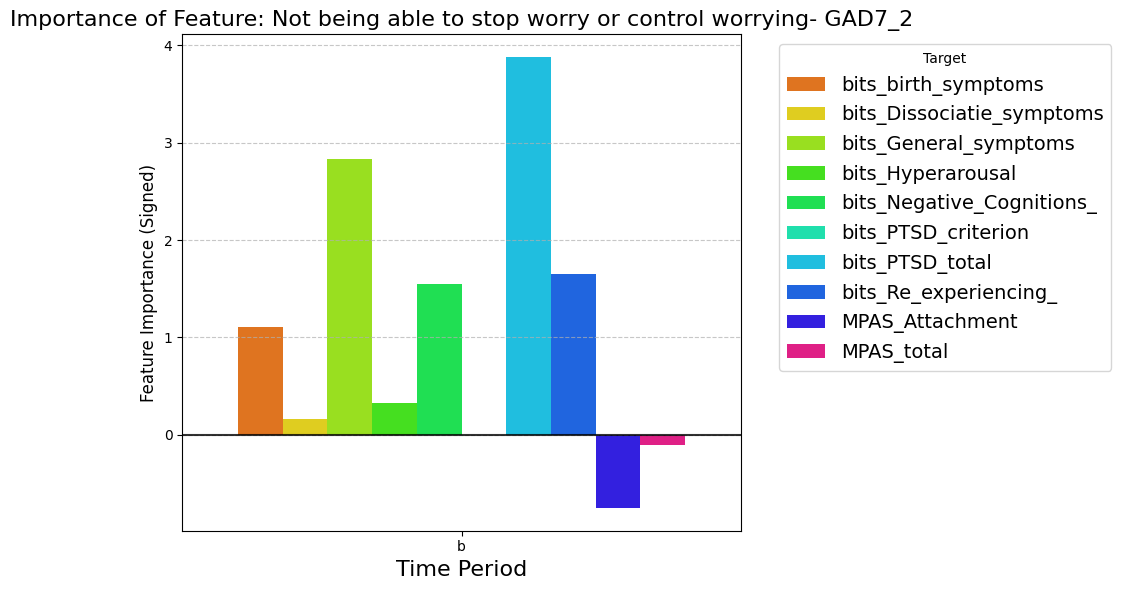

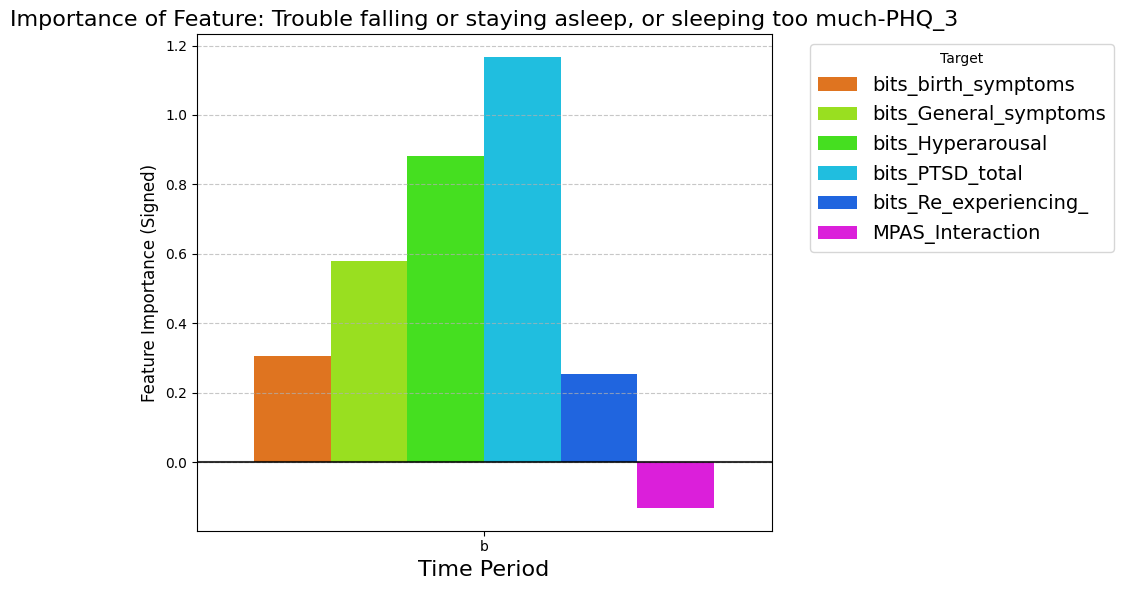

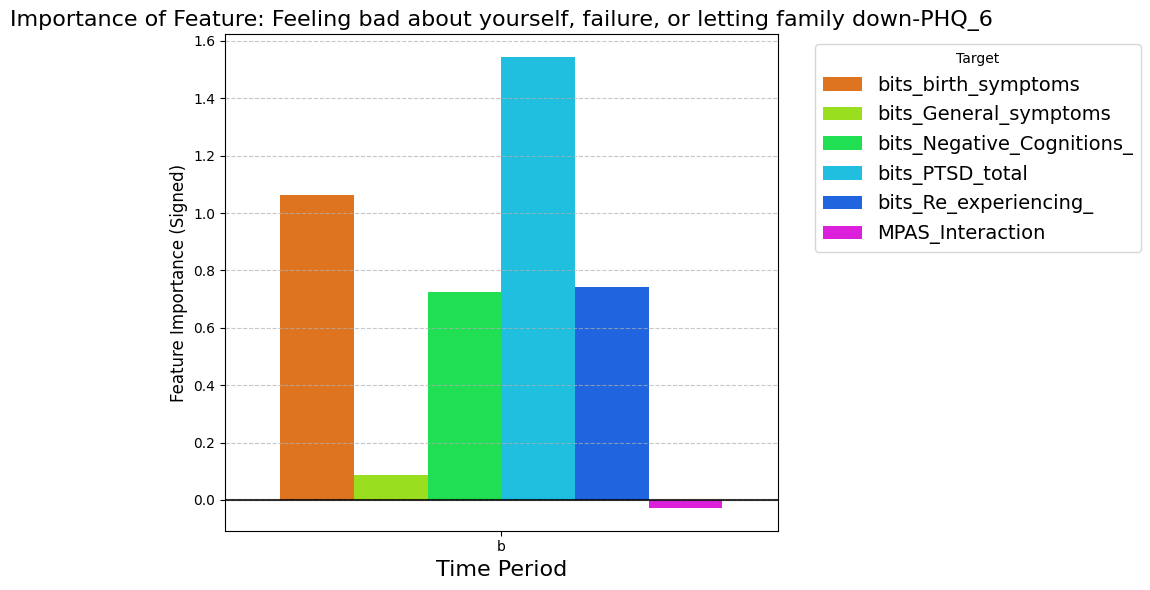

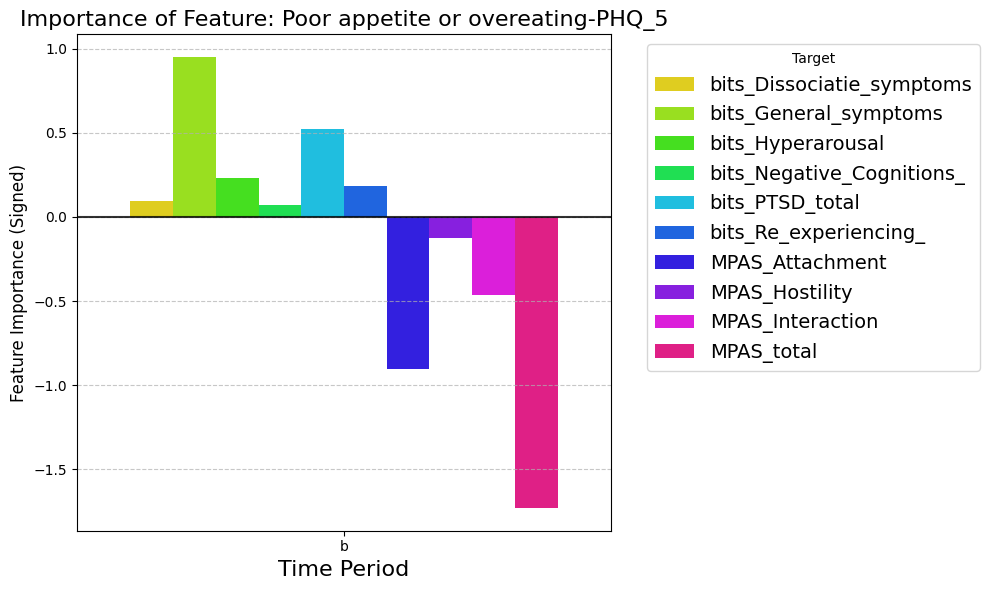

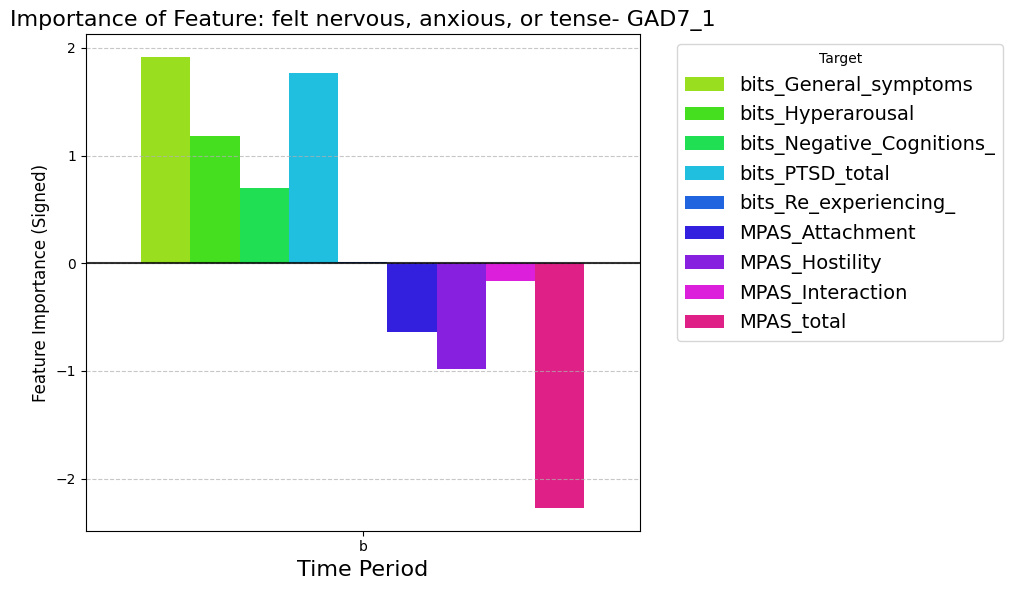

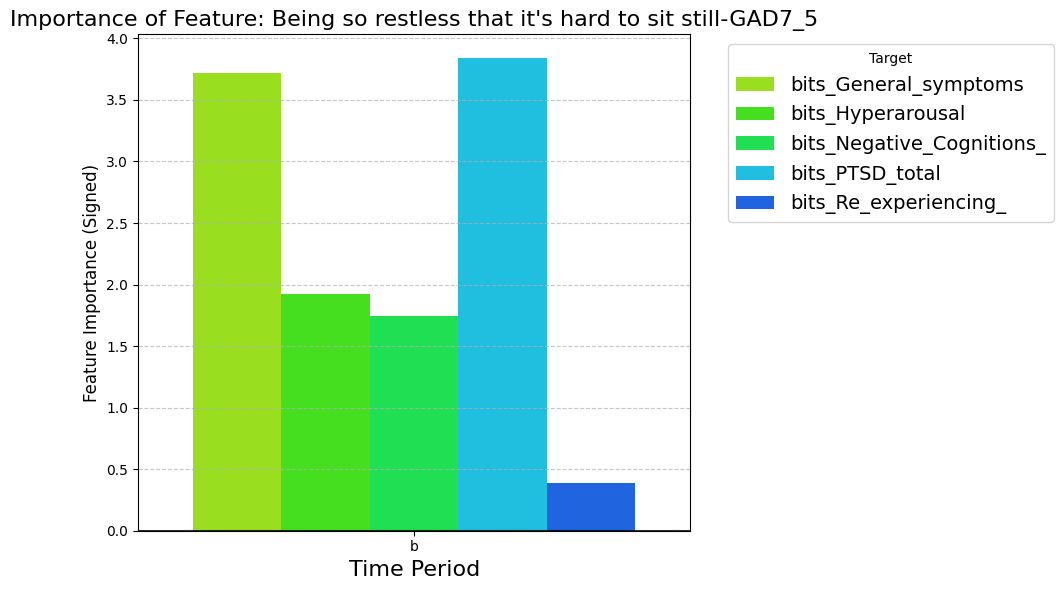

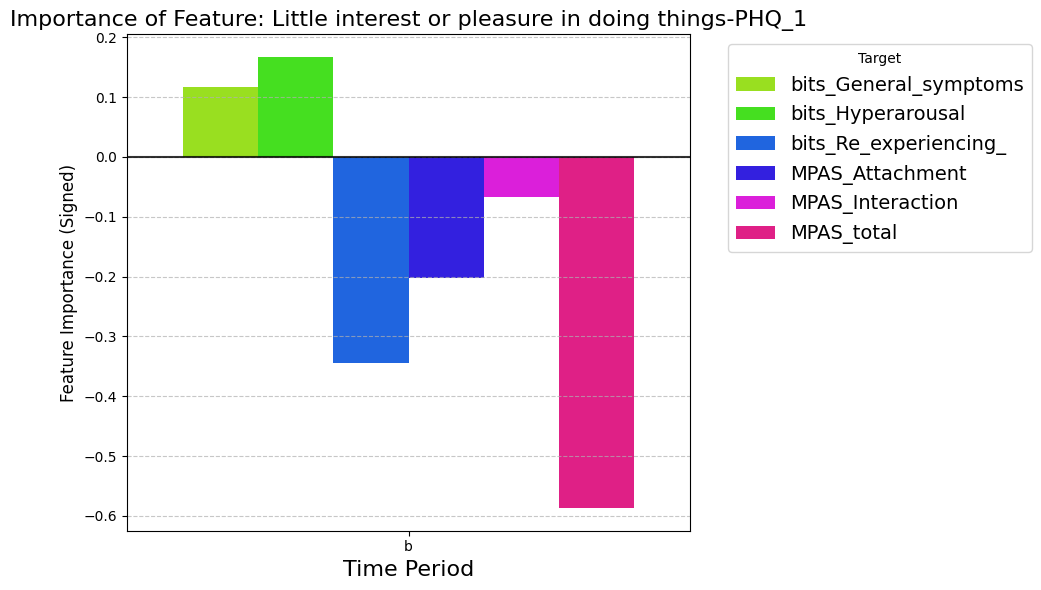

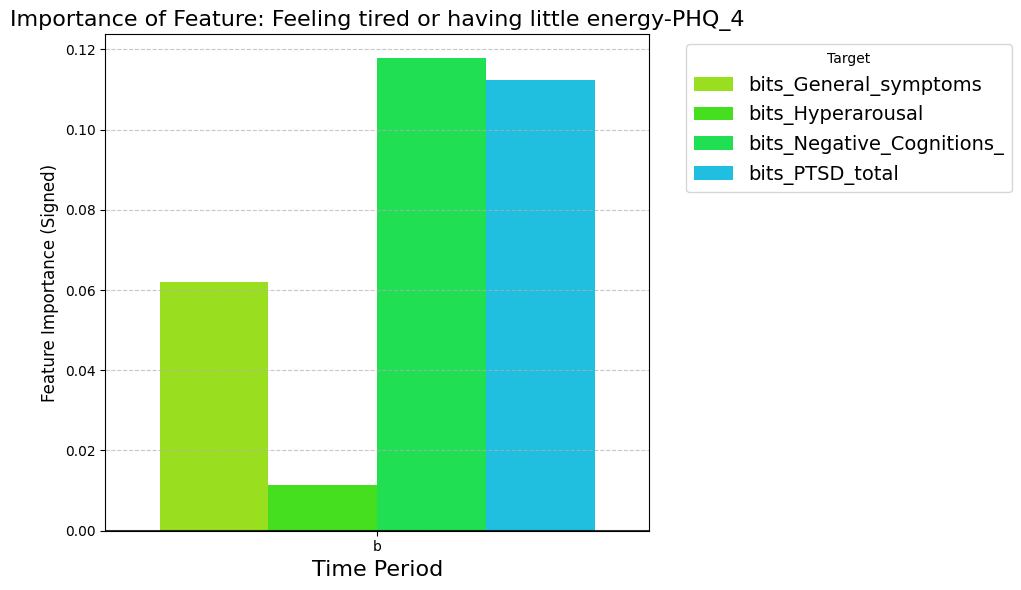

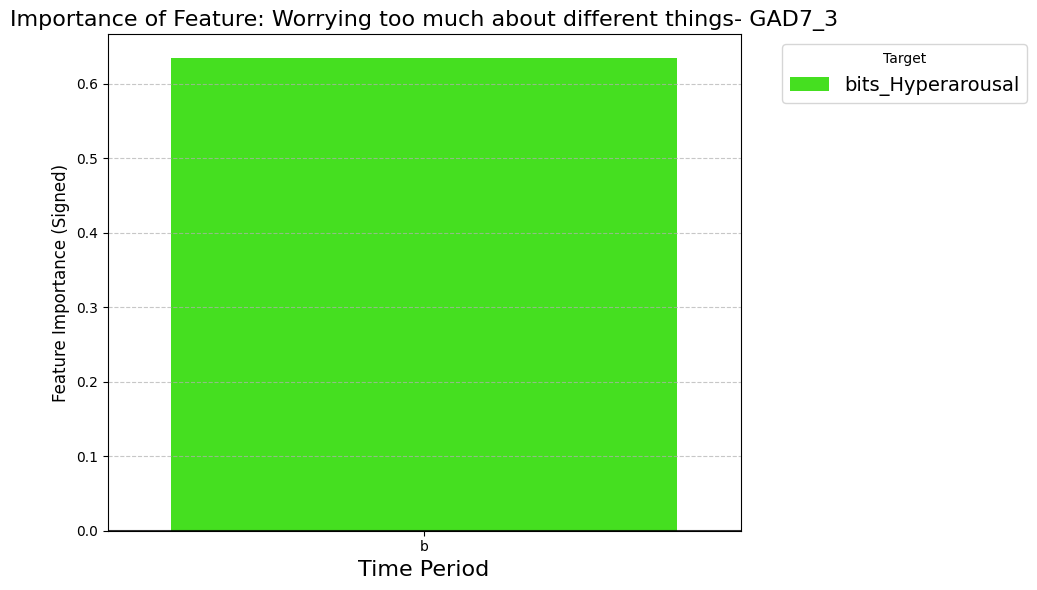

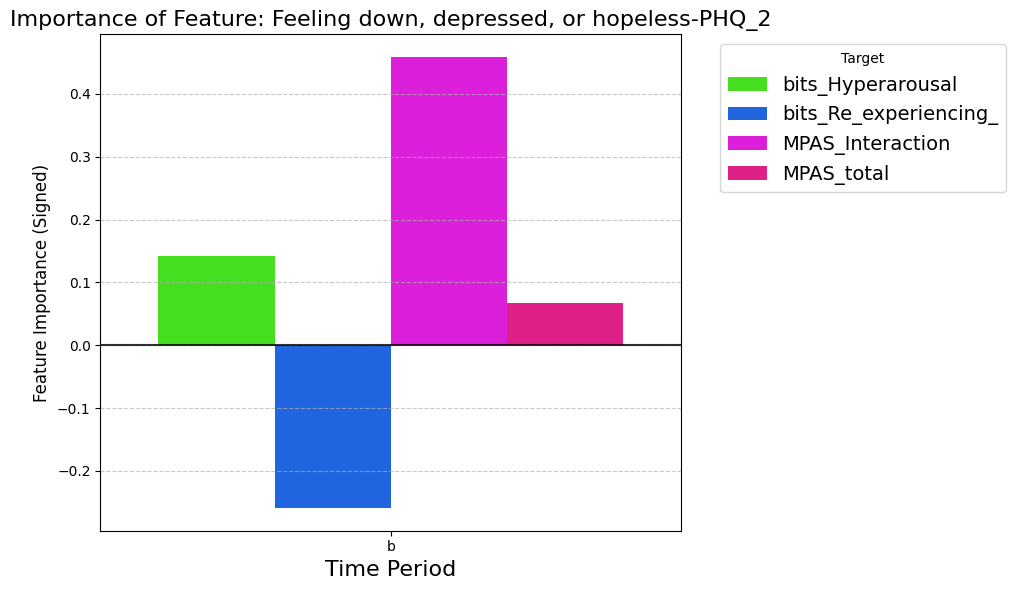

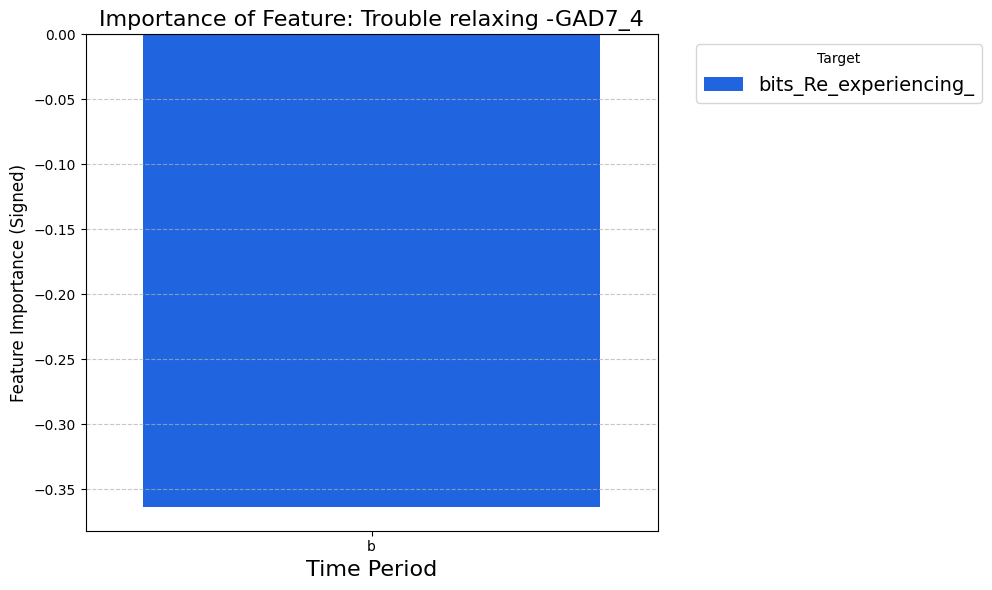

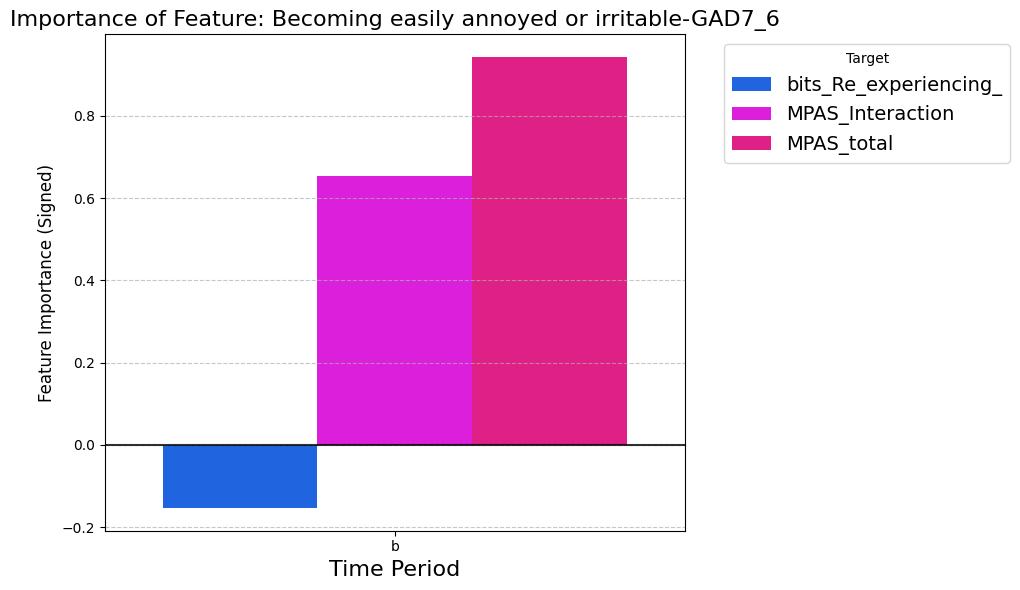

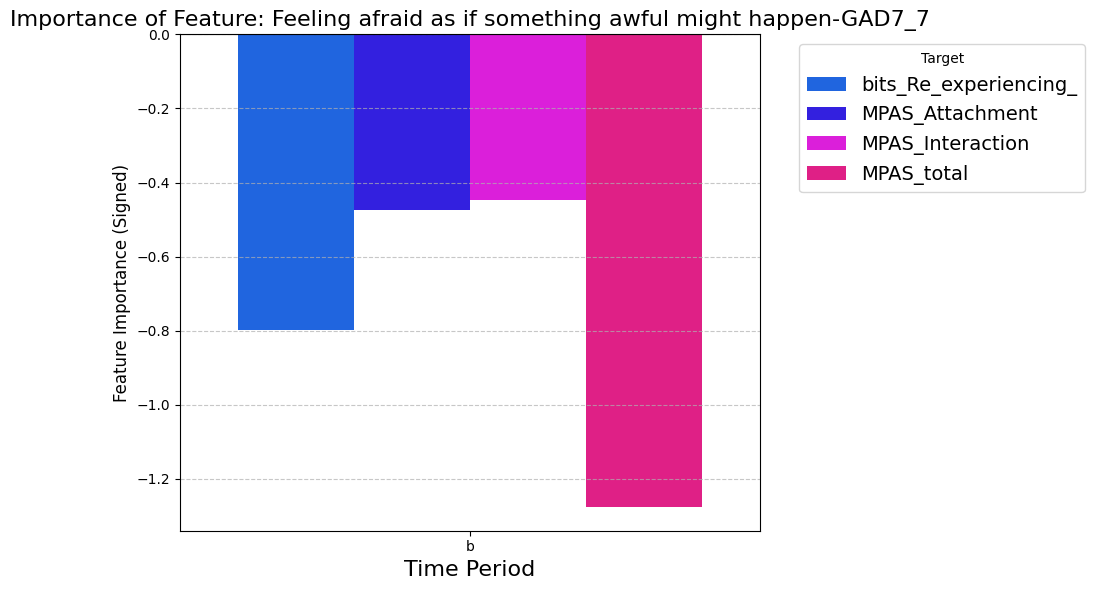

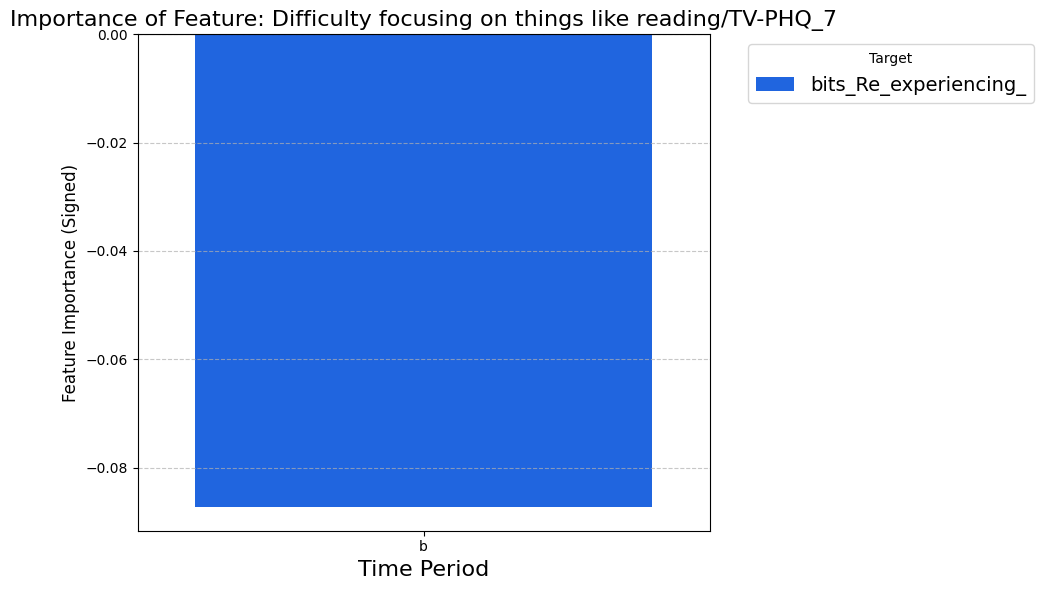

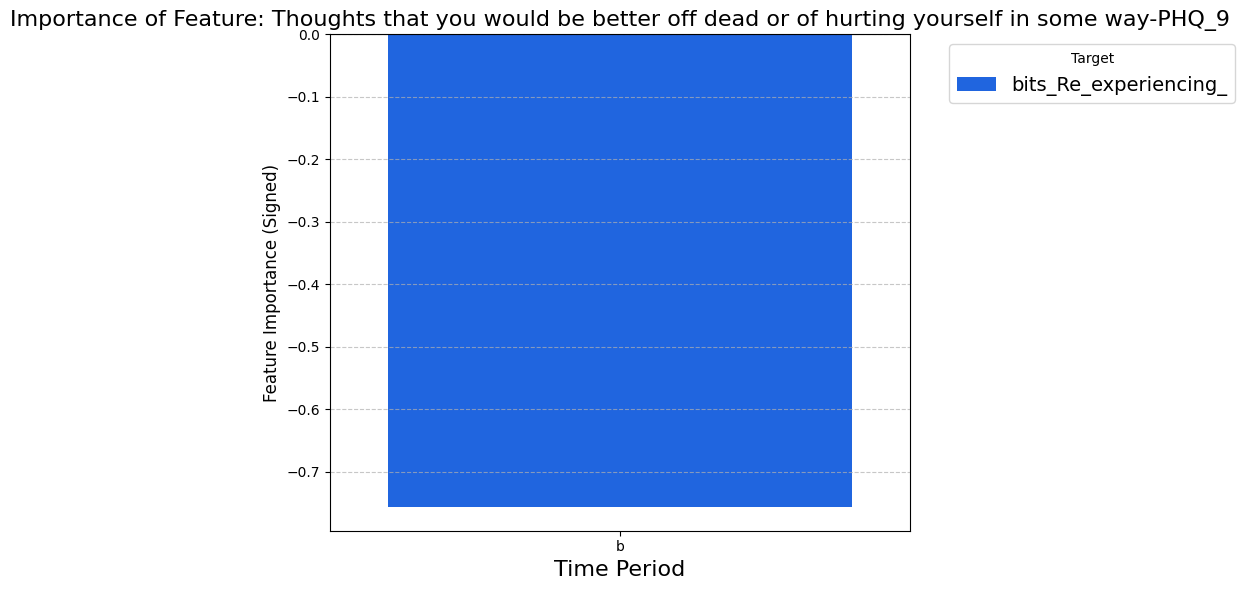


Completed plotting for 15 features. Plots saved to 'feature_bar_plots_dynamic_legend'.


In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

# ==============================================================================
# Add the helper function here, outside of the main plotting function
# ==============================================================================
def rgb_to_hex(rgb):
    """Converts a tuple of floats (0.0-1.0) to a Hex color string."""
    # Ensure values are capped at 1.0 before scaling
    r = min(1.0, rgb[0])
    g = min(1.0, rgb[1])
    b = min(1.0, rgb[2])
    return '#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255))
# ==============================================================================

# --- FEATURE MAPPING ---
FEATURE_MAPPING = {
    "GAD7_1": "felt nervous, anxious, or tense- GAD7_1",
    "GAD7_2": "Not being able to stop worry or control worrying- GAD7_2",
    "GAD7_3": "Worrying too much about different things- GAD7_3",
    "GAD7_4": "Trouble relaxing -GAD7_4",
    "GAD7_5": "Being so restless that it's hard to sit still-GAD7_5",
    "GAD7_6": "Becoming easily annoyed or irritable-GAD7_6",
    "GAD7_7": "Feeling afraid as if something awful might happen-GAD7_7",
    "PHQ_1": "Little interest or pleasure in doing things-PHQ_1",
    "PHQ_2": "Feeling down, depressed, or hopeless-PHQ_2",
    "PHQ_3": "Trouble falling or staying asleep, or sleeping too much-PHQ_3",
    "PHQ_4": "Feeling tired or having little energy-PHQ_4",
    "PHQ_5": "Poor appetite or overeating-PHQ_5",
    "PHQ_6": "Feeling bad about yourself, failure, or letting family down-PHQ_6",
    "PHQ_7": "Difficulty focusing on things like reading/TV-PHQ_7",
    "PHQ_8": "Changes in activity: Slowed speech/movement or restlessness/agitation-PHQ_8",
    "PHQ_9": "Thoughts that you would be better off dead or of hurting yourself in some way-PHQ_9",
    "DEFAULT_SENTENCE": "Feature Importance" 
}
# -----------------------

# Define the base directory (from previous step's configuration)
BASE_DIR = r"only_Q_outputs\combined\regression\without-pca"
COMBINED_RESULTS_DIR = os.path.join(BASE_DIR, "combined_target_results_normalized")


def plot_all_features_across_targets(search_dir, feature_map, file_pattern="*_combined_feature_importance.csv"):
    """
    Loads all combined feature importance CSVs, unifies data, prints the fixed 
    Hex color map, and generates a grouped bar plot for each unique feature,
    correctly handling both positive and negative importance values.
    """
    all_data = []
    
    # 1. Load and Unify All Combined Target Files
    print(f"Searching for files in directory: {search_dir} matching pattern: {file_pattern}")
    search_path = os.path.join(search_dir, file_pattern)
    file_list = glob.glob(search_path)

    if not file_list:
        print("❌ Error: No combined feature importance files found in the specified directory.")
        return

    # NOTE: Using 'after' as per the user's latest TIME_PERIODS definition
    TIME_PERIODS = ["b"] 

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        match = re.match(r"(.+)_combined_feature_importance\.csv", file_name)
        target_name = match.group(1) if match else "Unknown_Target"
            
        try:
            df = pd.read_csv(file_path)
            
            # Filter to include features where ANY time period is non-zero (positive or negative)
            df_filtered = df[(df[TIME_PERIODS] != 0).any(axis=1)].copy() 
            
            # Only proceed if there are non-zero features for this target
            if df_filtered.empty:
                 continue

            df_long = df_filtered.melt(
                id_vars='feature', value_vars=TIME_PERIODS, var_name='Time_Period', value_name='Importance'
            )
            df_long['Target'] = target_name
            all_data.append(df_long)
            
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    if not all_data: 
        print("No data with non-zero importance found.")
        return

    master_df = pd.concat(all_data, ignore_index=True)
    master_df['Importance'] = pd.to_numeric(master_df['Importance'], errors='coerce')
    master_df.dropna(subset=['Importance'], inplace=True)
    time_period_category = pd.CategoricalDtype(categories=TIME_PERIODS, ordered=True)
    master_df['Time_Period'] = master_df['Time_Period'].astype(time_period_category)


    # ==============================================================================
    # --- HEX COLOR MAPPING AND PRINTING CODE ---
    # ==============================================================================
    all_possible_targets = master_df['Target'].unique().tolist()
    
    # Generate a color palette big enough for all targets
    fixed_palette_rgb = sns.color_palette("hsv", len(all_possible_targets))
    
    # Create the color mapping dictionary (Target -> RGB tuple)
    target_rgb_map = dict(zip(all_possible_targets, fixed_palette_rgb))

    # Create and Print the Hex Color Map
    target_color_map = {} # This will store the RGB tuple map for plotting
    target_hex_map = {} # This will store the Hex map for printing
    
    print("\n--- Fixed Hex Color Codes for All Targets ---")
    for target, rgb_color in target_rgb_map.items():
        hex_code = rgb_to_hex(rgb_color)
        target_hex_map[target] = hex_code
        print(f"Target: {target:<30} | Hex Code: {hex_code}")
    print("---------------------------------------------")

    # Set the plotting palette to the RGB map
    target_color_map = target_rgb_map
    # ==============================================================================


    # 2. Iterate and Plot for Each Unique Feature
    output_dir = "feature_bar_plots_dynamic_legend"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nGenerating plots in directory: {output_dir}")
    
    unique_features = master_df['feature'].unique()
    print(f"Found {len(unique_features)} unique features to plot.")
    
    features_to_plot = unique_features
    MAX_PLOTS = 100
    if len(unique_features) > MAX_PLOTS:
        # Limit plots to top N by total absolute importance
        print(f"Warning: Limiting to the top {MAX_PLOTS} features for plot generation responsiveness.")
        # Sort by the sum of ABSOLUTE importance to select the most relevant features
        feature_importance_sum = master_df.groupby('feature')['Importance'].apply(lambda x: x.abs().sum()).sort_values(ascending=False)
        features_to_plot = feature_importance_sum.head(MAX_PLOTS).index
    
    unique_targets = master_df['Target'].nunique()
    
    for feature_name in features_to_plot:
        
        # --- FIX: Filter to show only NON-ZERO importance (positive OR negative) ---
        feature_df = master_df[
            (master_df['feature'] == feature_name) & (master_df['Importance'] != 0)
        ].copy()
        
        # If no target has non-zero importance for this feature, skip the plot
        if feature_df.empty:
            continue
        
        # Get descriptive sentence for the title
        # Note: Added error handling for features not exactly matching the map key structure
        base_feature_name = feature_name.split('_', 1)[0] if '_' in feature_name else feature_name
        plot_title_sentence = feature_map.get(feature_name, feature_map.get(base_feature_name, f"{feature_map['DEFAULT_SENTENCE']} ({feature_name})"))
        
        # Calculate figure size
        fig_height = max(5, unique_targets * 0.5) 

        plt.figure(figsize=(12, fig_height)) 
        
        sns.barplot(
            data=feature_df, 
            x='Time_Period', 
            y='Importance', 
            hue='Target', 
            errorbar=None,
            palette=target_color_map # Use the fixed color map (RGB tuple version)
        )

        # ADDED: Draw a horizontal line at y=0 to clearly distinguish positive/negative
        plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.8)

        # Set plot details
        plt.title(f'Importance of Feature: {plot_title_sentence}', fontsize=16)
        plt.xlabel('Time Period', fontsize=16)
        # UPDATED Y-label to reflect signed importance
        plt.ylabel('Feature Importance (Signed)', fontsize=12) 
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 14)
        
        # Save the plot
        safe_feature_name = re.sub(r'[^\w\s-]', '', feature_name).strip().replace(' ', '_')
        plot_filename = os.path.join(output_dir, f"{safe_feature_name}_signed_importance_by_target.png")
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig(plot_filename)
        plt.show()
        plt.close()

    print(f"\nCompleted plotting for {len(features_to_plot)} features. Plots saved to '{output_dir}'.")

# Execute the function with the correct directory path and feature map
plot_all_features_across_targets(search_dir=COMBINED_RESULTS_DIR, feature_map=FEATURE_MAPPING)

In [55]:
import pandas as pd
import numpy as np
import os
# We assume the run_pca_regression_with_feature_importance function is defined above this script

# --- Define Constants and Paths ---

# 1. Input Files
PC_TRAJECTORIES_PATH = r"only_Q_outputs\combined\regression\ALL_PC_trajectories.csv" 
TARGETS_INPUT_PATH = r"only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv" 
PC_LOADINGS_PATH = r"only_Q_outputs\combined\regression\pca_all_loadings_full_table.csv" 

# 2. Output Paths
OUTPUT_BASE_DIR = r"only_Q_outputs\combined\regression\with-pca"
FINAL_SUMMARY_CSV = os.path.join(OUTPUT_BASE_DIR, "pca_regression_summary_results.csv")
TARGET_IMPORTANCE_DIR = os.path.join(OUTPUT_BASE_DIR, "pc_backcalculated_importance")

# Ensure output directory exists
os.makedirs(TARGET_IMPORTANCE_DIR, exist_ok=True)


# --- Target List ---
TARGETS = [
    'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
    'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 
    'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ', 
    'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 
    'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 
    'after_MPAS_Hostility', 'after_MPAS_Interaction'
]


# ==============================================================================
# 3. Load DataFrames
# ==============================================================================

try:
    # 1. Load PC Trajectories (features for Lasso)
    pc_df_input = pd.read_csv(PC_TRAJECTORIES_PATH)
    print(f"Loaded PC Trajectories: {PC_TRAJECTORIES_PATH}")
    
    # 2. Load Targets (Y variables)
    targets_df_input = pd.read_csv(TARGETS_INPUT_PATH)
    print(f"Loaded Targets: {TARGETS_INPUT_PATH}")
    
    # 3. Load PC Loadings (weights for back-calculation)
    pc_loadings_df_input = pd.read_csv(PC_LOADINGS_PATH)
    print(f"Loaded PC Loadings: {PC_LOADINGS_PATH}")
    
except FileNotFoundError as e:
    print(f"\n❌ ERROR: Required file not found: {e.filename}")
    print("Please ensure you have run the loading function for your targets and the PC Loadings function first, or upload the missing files.")
    # Stop execution since data is missing
    exit()
except Exception as e:
    print(f"\n❌ ERROR during data loading: {e}")
    exit()


# ==============================================================================
# 4. Call the Function
# ==============================================================================

print("\n--- Starting PCA-based Lasso Regression ---")

results_df = run_pca_regression_with_feature_importance(
    pc_df=pc_df_input,
    targets_df=targets_df_input,
    pc_loadings_df=pc_loadings_df_input,
    targets=TARGETS,
    pca_prefix='PC',  # Based on your column names (PC1_b, PC2_b, etc.)
    save_csv_path=FINAL_SUMMARY_CSV,
    save_target_csv_dir=TARGET_IMPORTANCE_DIR
)

print("\n--- PCA Regression Complete ---")
if results_df is not None:
    print(f"Final summary saved to: {FINAL_SUMMARY_CSV}")
    print(f"Individual feature importance CSVs saved to: {TARGET_IMPORTANCE_DIR}")

Loaded PC Trajectories: only_Q_outputs\combined\regression\ALL_PC_trajectories.csv
Loaded Targets: only_Q_outputs\combined\regression\regression_parameters_bits_mpas_ders_des.csv
Loaded PC Loadings: only_Q_outputs\combined\regression\pca_all_loadings_full_table.csv

--- Starting PCA-based Lasso Regression ---

✅ Regression results for Target: after_bits_PTSD_total (R2: 0.5488)
📁 Saved back-calculated importance for Target 'after_bits_PTSD_total' to: only_Q_outputs\combined\regression\with-pca\pc_backcalculated_importance\after_bits_PTSD_total_feature_importance_pca_backcalculated.csv

✅ Regression results for Target: after_bits_birth_symptoms (R2: 0.0950)
📁 Saved back-calculated importance for Target 'after_bits_birth_symptoms' to: only_Q_outputs\combined\regression\with-pca\pc_backcalculated_importance\after_bits_birth_symptoms_feature_importance_pca_backcalculated.csv

✅ Regression results for Target: after_bits_General_symptoms (R2: 0.6613)
📁 Saved back-calculated importance for Tar

c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\nogag\PycharmProjects\technion\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the feature


✅ Regression results for Target: after_bits_PTSD_criterion (R2: 0.0000)
📁 Saved back-calculated importance for Target 'after_bits_PTSD_criterion' to: only_Q_outputs\combined\regression\with-pca\pc_backcalculated_importance\after_bits_PTSD_criterion_feature_importance_pca_backcalculated.csv

✅ Regression results for Target: after_bits_Re_experiencing  (R2: 0.1239)
📁 Saved back-calculated importance for Target 'after_bits_Re_experiencing ' to: only_Q_outputs\combined\regression\with-pca\pc_backcalculated_importance\after_bits_Re_experiencing__feature_importance_pca_backcalculated.csv

✅ Regression results for Target: after_bits_Avoidance  (R2: 0.0000)
📁 Saved back-calculated importance for Target 'after_bits_Avoidance ' to: only_Q_outputs\combined\regression\with-pca\pc_backcalculated_importance\after_bits_Avoidance__feature_importance_pca_backcalculated.csv

✅ Regression results for Target: after_bits_Negative_Cognitions  (R2: 0.3965)
📁 Saved back-calculated importance for Target 'afte

Searching for files in directory: only_Q_outputs\combined\regression\without-pca\combined_target_results_normalized matching pattern: *_combined_feature_importance.csv
Error reading MAAS_total_combined_feature_importance.csv: "None of [Index(['after'], dtype='object')] are in the [columns]"

--- Fixed Hex Color Codes for All Targets ---
Target: bits_Avoidance_                | Hex Code: #ff7000
Target: bits_birth_symptoms            | Hex Code: #ffe600
Target: bits_Dissociatie_symptoms      | Hex Code: #a1ff00
Target: bits_General_symptoms          | Hex Code: #31ff00
Target: bits_Hyperarousal              | Hex Code: #00ff44
Target: bits_Negative_Cognitions_      | Hex Code: #00ffba
Target: bits_PTSD_total                | Hex Code: #00d2ff
Target: bits_Re_experiencing_          | Hex Code: #005cff
Target: MPAS_Attachment                | Hex Code: #1900ff
Target: MPAS_Hostility                 | Hex Code: #8900ff
Target: MPAS_Interaction               | Hex Code: #f900f9
Target: MPAS

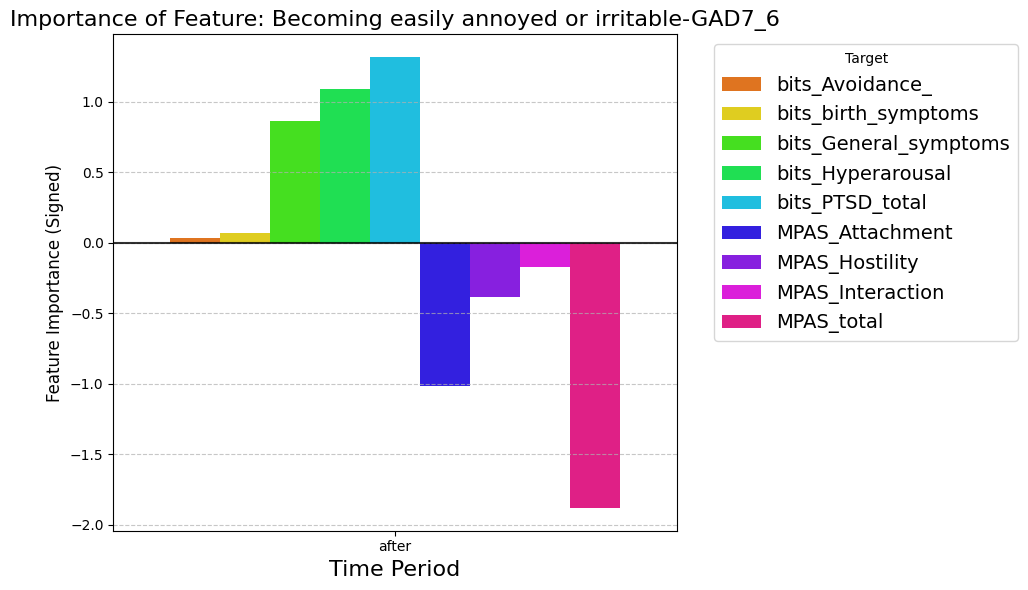

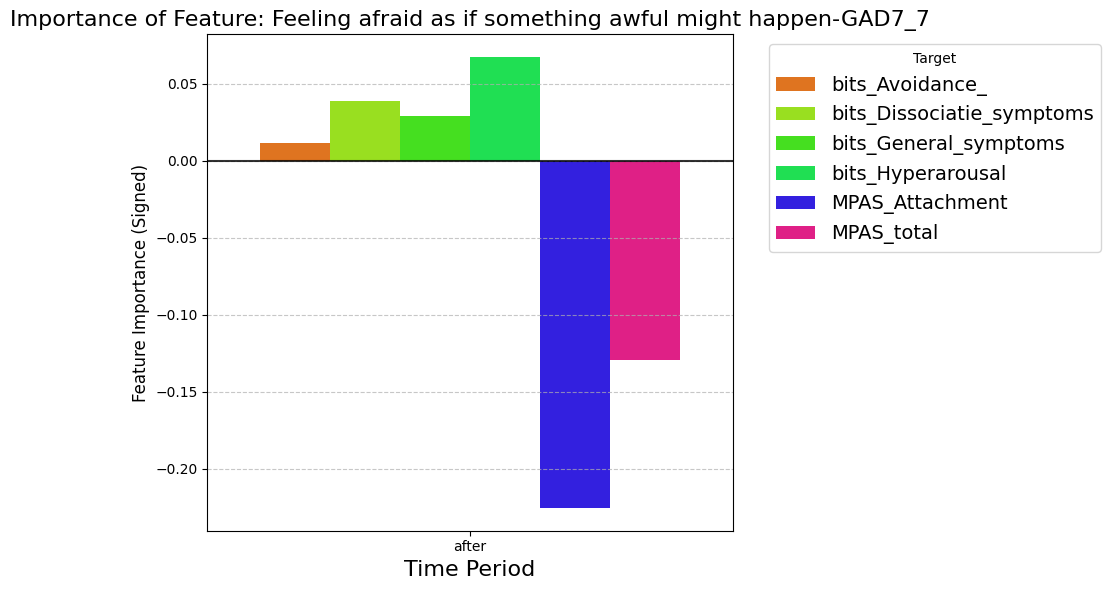

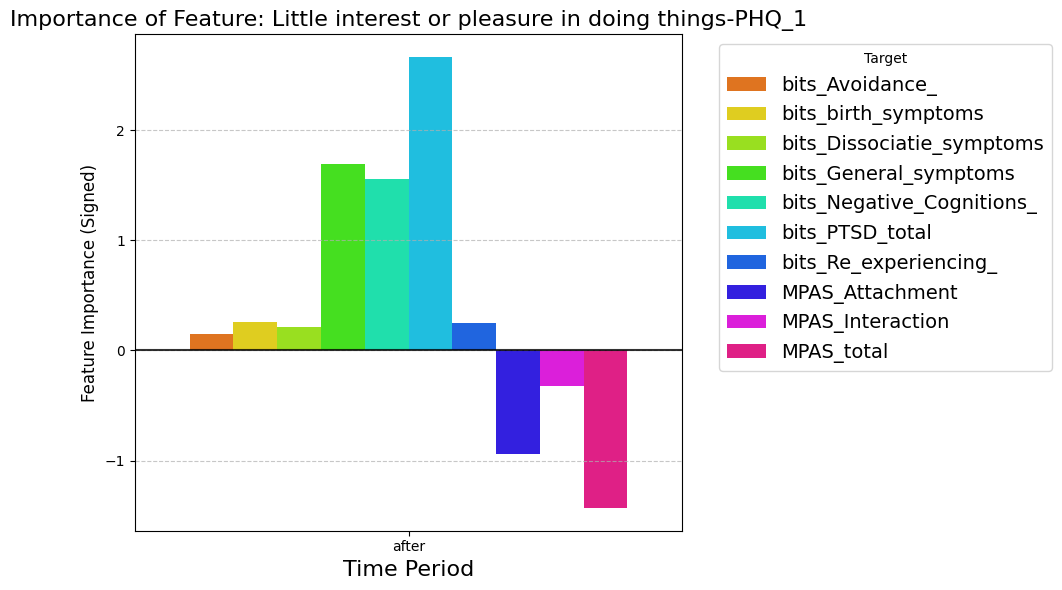

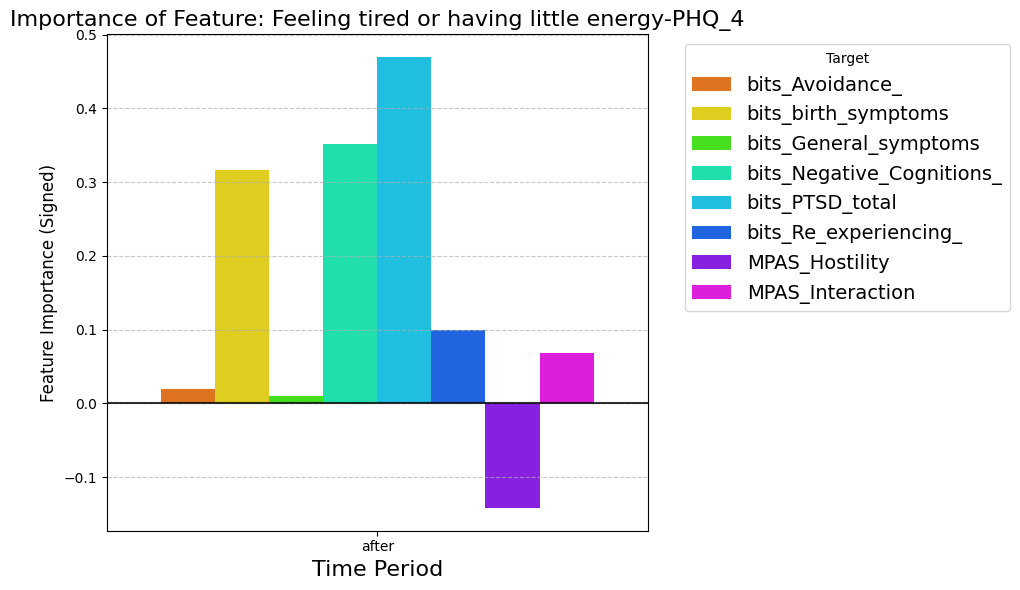

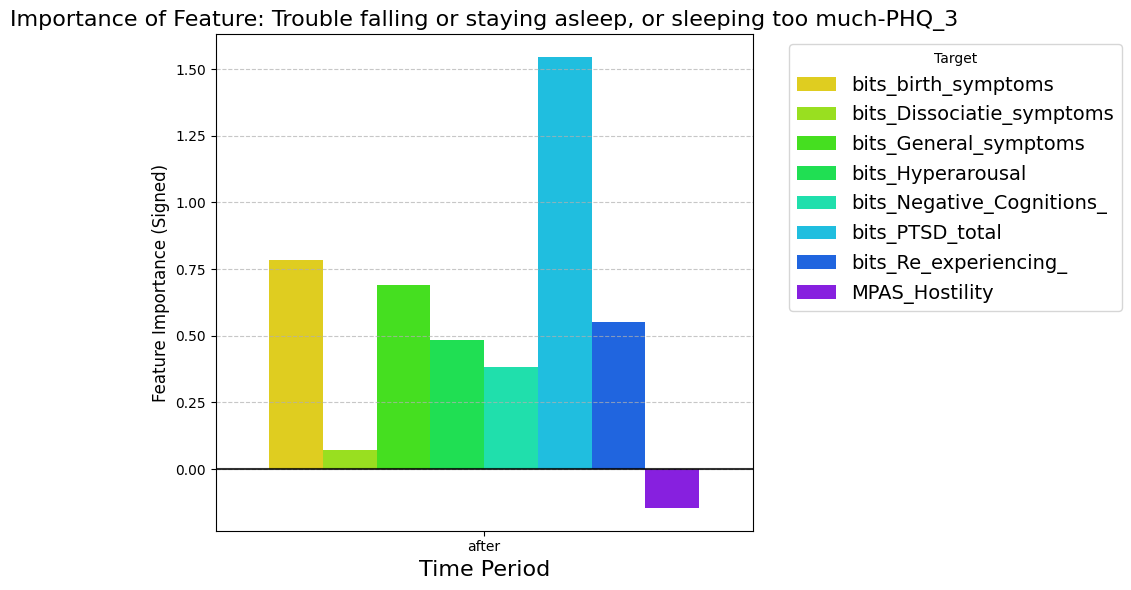

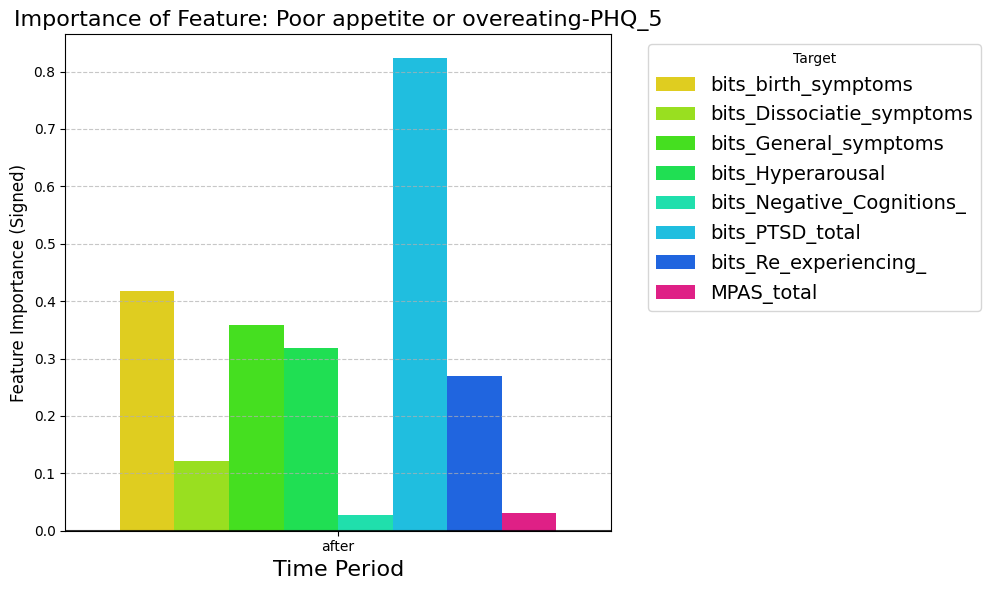

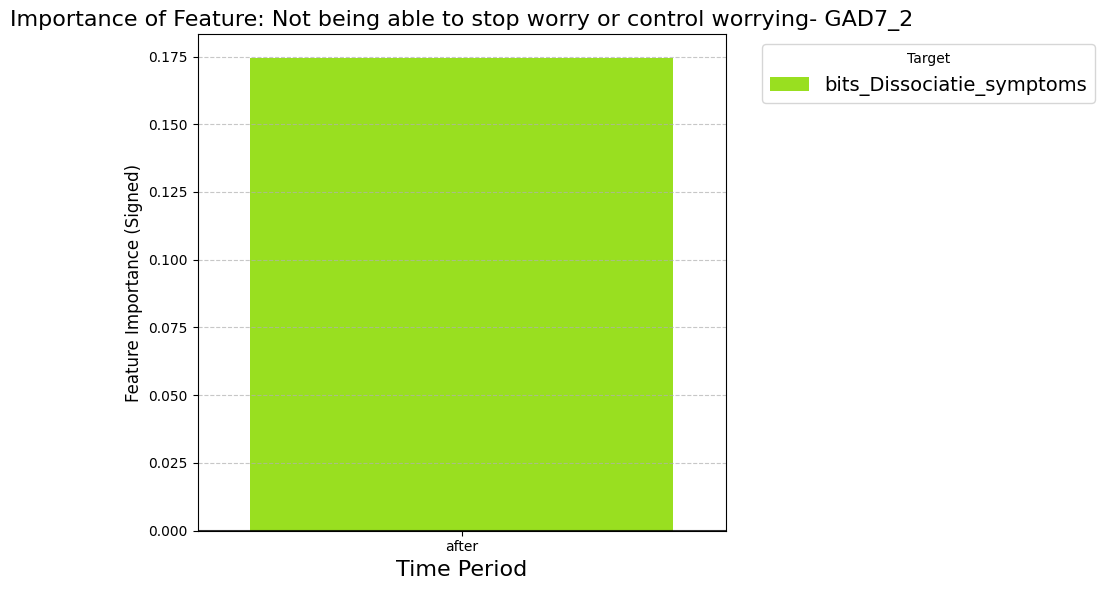

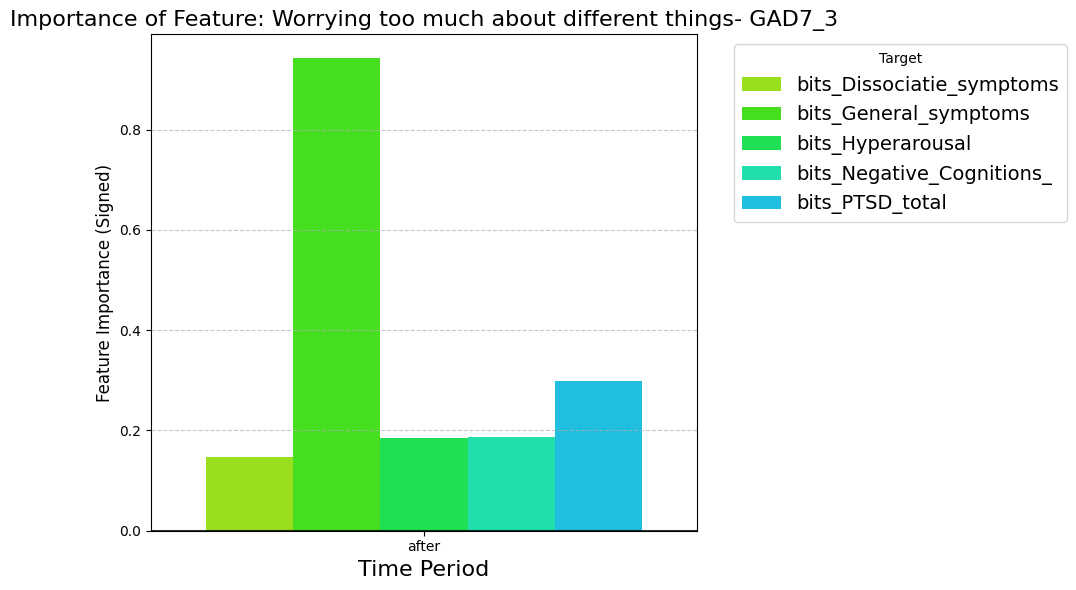

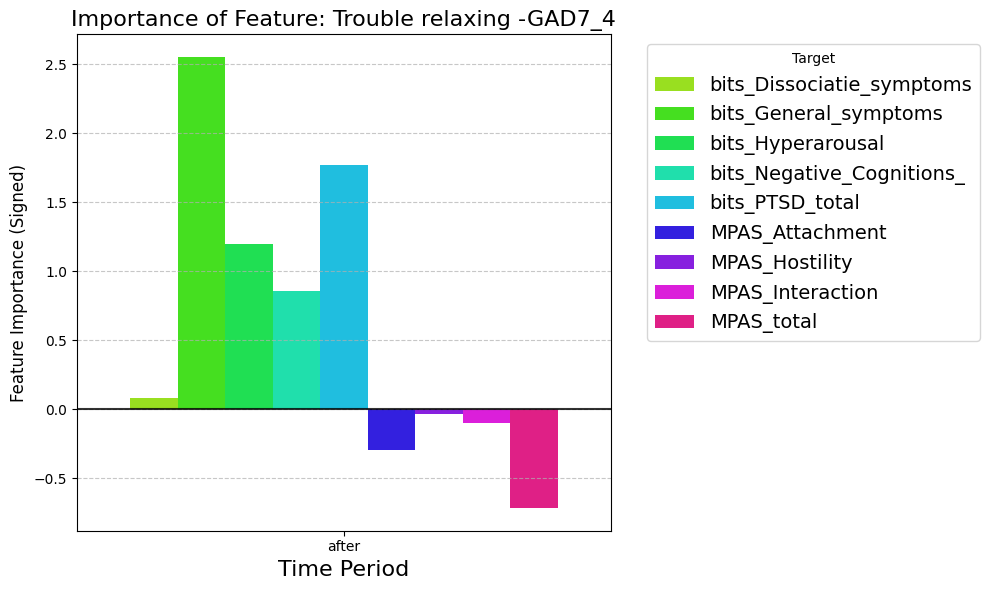

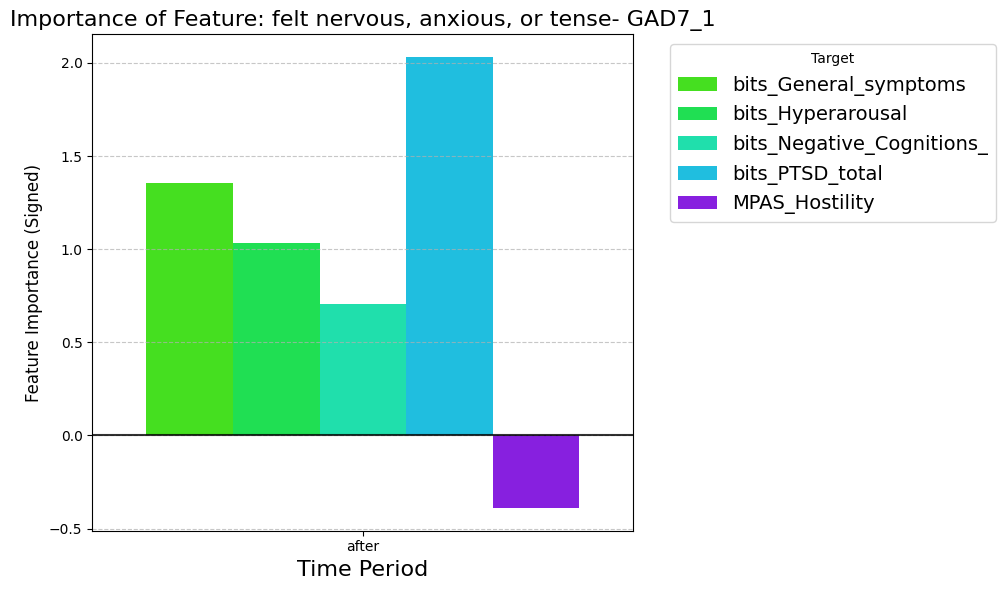

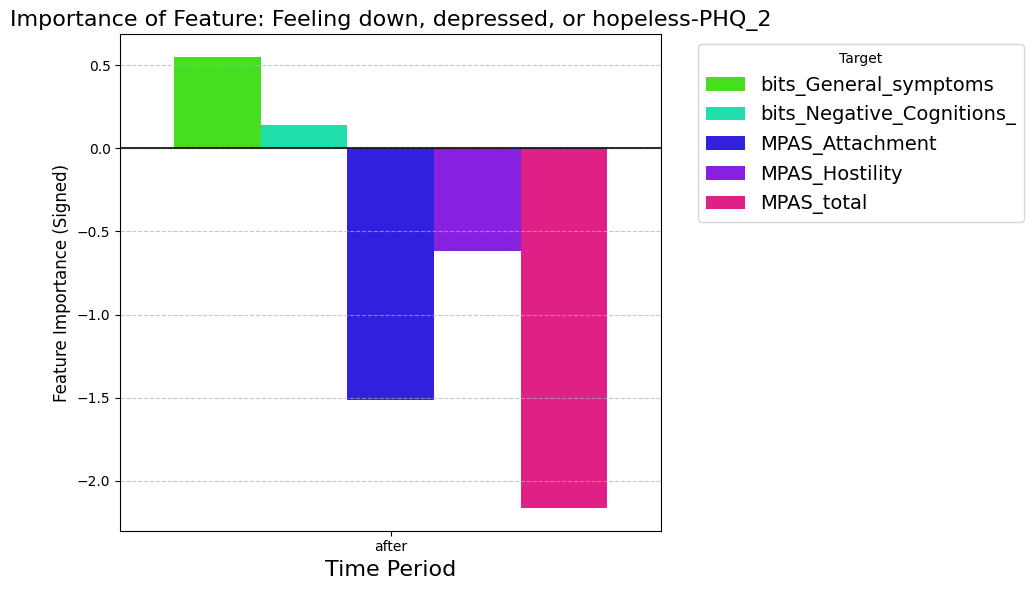

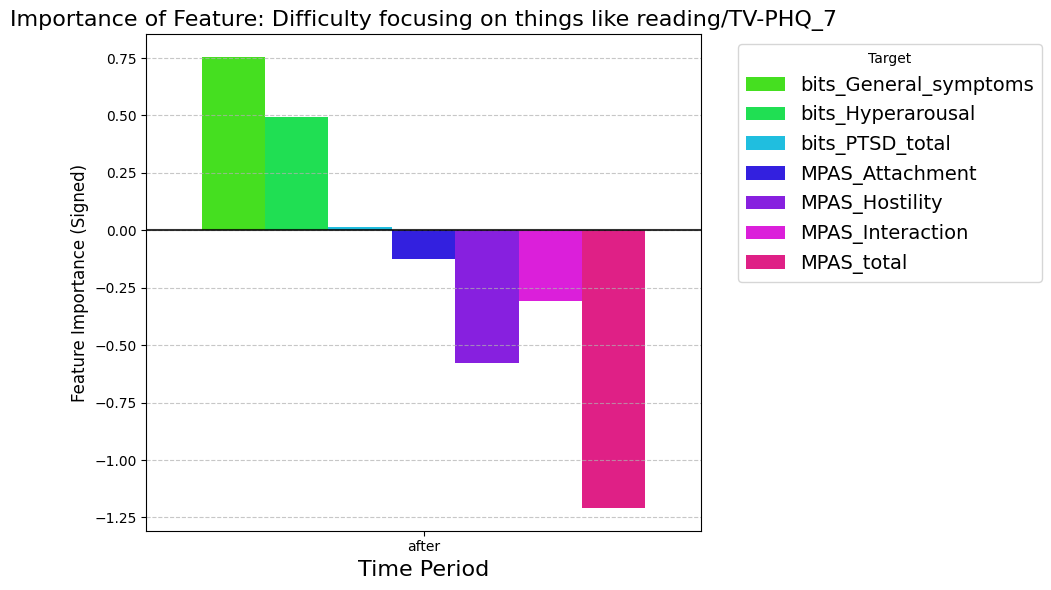

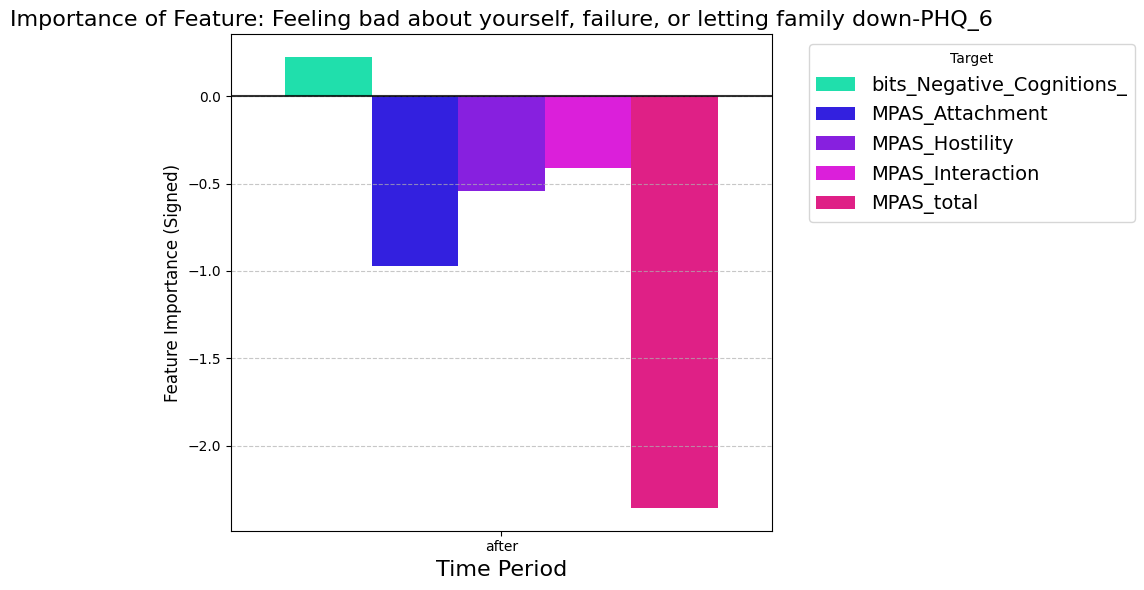

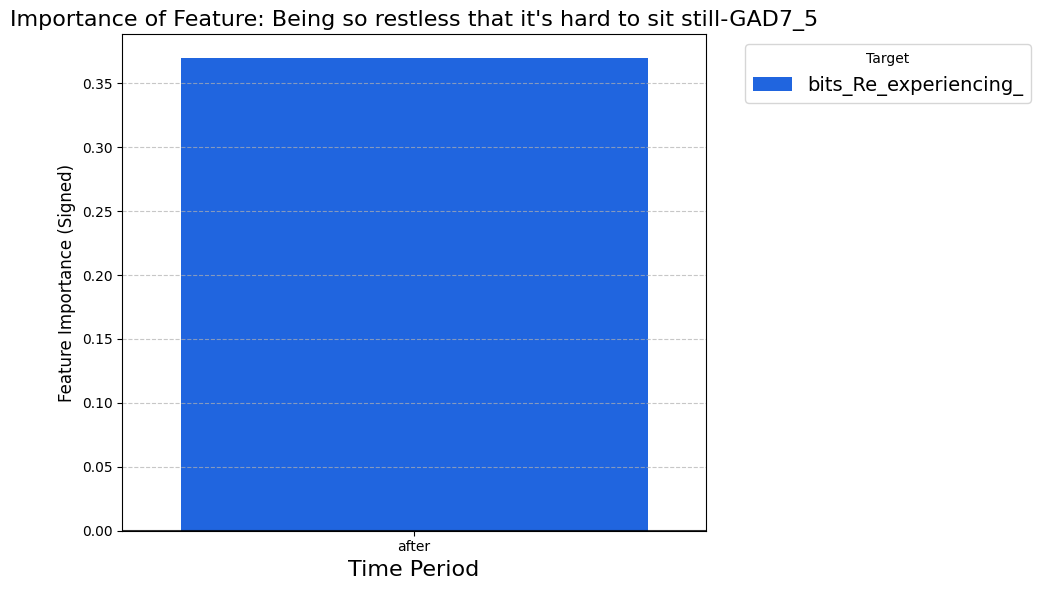


Completed plotting for 14 features. Plots saved to 'feature_bar_plots_dynamic_legend'.


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re

# ==============================================================================
# Add the helper function here, outside of the main plotting function
# ==============================================================================
def rgb_to_hex(rgb):
    """Converts a tuple of floats (0.0-1.0) to a Hex color string."""
    # Ensure values are capped at 1.0 before scaling
    r = min(1.0, rgb[0])
    g = min(1.0, rgb[1])
    b = min(1.0, rgb[2])
    return '#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255))
# ==============================================================================

# --- FEATURE MAPPING ---
FEATURE_MAPPING = {
    "GAD7_1": "felt nervous, anxious, or tense- GAD7_1",
    "GAD7_2": "Not being able to stop worry or control worrying- GAD7_2",
    "GAD7_3": "Worrying too much about different things- GAD7_3",
    "GAD7_4": "Trouble relaxing -GAD7_4",
    "GAD7_5": "Being so restless that it's hard to sit still-GAD7_5",
    "GAD7_6": "Becoming easily annoyed or irritable-GAD7_6",
    "GAD7_7": "Feeling afraid as if something awful might happen-GAD7_7",
    "PHQ_1": "Little interest or pleasure in doing things-PHQ_1",
    "PHQ_2": "Feeling down, depressed, or hopeless-PHQ_2",
    "PHQ_3": "Trouble falling or staying asleep, or sleeping too much-PHQ_3",
    "PHQ_4": "Feeling tired or having little energy-PHQ_4",
    "PHQ_5": "Poor appetite or overeating-PHQ_5",
    "PHQ_6": "Feeling bad about yourself, failure, or letting family down-PHQ_6",
    "PHQ_7": "Difficulty focusing on things like reading/TV-PHQ_7",
    "PHQ_8": "Changes in activity: Slowed speech/movement or restlessness/agitation-PHQ_8",
    "PHQ_9": "Thoughts that you would be better off dead or of hurting yourself in some way-PHQ_9",
    "DEFAULT_SENTENCE": "Feature Importance" 
}
# -----------------------

# Define the base directory (from previous step's configuration)
BASE_DIR = r"only_Q_outputs\combined\regression\without-pca"
COMBINED_RESULTS_DIR = os.path.join(BASE_DIR, "combined_target_results_normalized")


def plot_all_features_across_targets(search_dir, feature_map, file_pattern="*_combined_feature_importance.csv"):
    """
    Loads all combined feature importance CSVs, unifies data, prints the fixed 
    Hex color map, and generates a grouped bar plot for each unique feature,
    correctly handling both positive and negative importance values.
    """
    all_data = []
    
    # 1. Load and Unify All Combined Target Files
    print(f"Searching for files in directory: {search_dir} matching pattern: {file_pattern}")
    search_path = os.path.join(search_dir, file_pattern)
    file_list = glob.glob(search_path)

    if not file_list:
        print("❌ Error: No combined feature importance files found in the specified directory.")
        return

    # NOTE: Using 'after' as per the user's latest TIME_PERIODS definition
    TIME_PERIODS = ["after"] 

    for file_path in file_list:
        file_name = os.path.basename(file_path)
        match = re.match(r"(.+)_combined_feature_importance\.csv", file_name)
        target_name = match.group(1) if match else "Unknown_Target"
            
        try:
            df = pd.read_csv(file_path)
            
            # Filter to include features where ANY time period is non-zero (positive or negative)
            df_filtered = df[(df[TIME_PERIODS] != 0).any(axis=1)].copy() 
            
            # Only proceed if there are non-zero features for this target
            if df_filtered.empty:
                 continue

            df_long = df_filtered.melt(
                id_vars='feature', value_vars=TIME_PERIODS, var_name='Time_Period', value_name='Importance'
            )
            df_long['Target'] = target_name
            all_data.append(df_long)
            
        except Exception as e:
            print(f"Error reading {file_name}: {e}")

    if not all_data: 
        print("No data with non-zero importance found.")
        return

    master_df = pd.concat(all_data, ignore_index=True)
    master_df['Importance'] = pd.to_numeric(master_df['Importance'], errors='coerce')
    master_df.dropna(subset=['Importance'], inplace=True)
    time_period_category = pd.CategoricalDtype(categories=TIME_PERIODS, ordered=True)
    master_df['Time_Period'] = master_df['Time_Period'].astype(time_period_category)


    # ==============================================================================
    # --- HEX COLOR MAPPING AND PRINTING CODE ---
    # ==============================================================================
    all_possible_targets = master_df['Target'].unique().tolist()
    
    # Generate a color palette big enough for all targets
    fixed_palette_rgb = sns.color_palette("hsv", len(all_possible_targets))
    
    # Create the color mapping dictionary (Target -> RGB tuple)
    target_rgb_map = dict(zip(all_possible_targets, fixed_palette_rgb))

    # Create and Print the Hex Color Map
    target_color_map = {} # This will store the RGB tuple map for plotting
    target_hex_map = {} # This will store the Hex map for printing
    
    print("\n--- Fixed Hex Color Codes for All Targets ---")
    for target, rgb_color in target_rgb_map.items():
        hex_code = rgb_to_hex(rgb_color)
        target_hex_map[target] = hex_code
        print(f"Target: {target:<30} | Hex Code: {hex_code}")
    print("---------------------------------------------")

    # Set the plotting palette to the RGB map
    target_color_map = target_rgb_map
    # ==============================================================================


    # 2. Iterate and Plot for Each Unique Feature
    output_dir = "feature_bar_plots_dynamic_legend"
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nGenerating plots in directory: {output_dir}")
    
    unique_features = master_df['feature'].unique()
    print(f"Found {len(unique_features)} unique features to plot.")
    
    features_to_plot = unique_features
    MAX_PLOTS = 100
    if len(unique_features) > MAX_PLOTS:
        # Limit plots to top N by total absolute importance
        print(f"Warning: Limiting to the top {MAX_PLOTS} features for plot generation responsiveness.")
        # Sort by the sum of ABSOLUTE importance to select the most relevant features
        feature_importance_sum = master_df.groupby('feature')['Importance'].apply(lambda x: x.abs().sum()).sort_values(ascending=False)
        features_to_plot = feature_importance_sum.head(MAX_PLOTS).index
    
    unique_targets = master_df['Target'].nunique()
    
    for feature_name in features_to_plot:
        
        # --- FIX: Filter to show only NON-ZERO importance (positive OR negative) ---
        feature_df = master_df[
            (master_df['feature'] == feature_name) & (master_df['Importance'] != 0)
        ].copy()
        
        # If no target has non-zero importance for this feature, skip the plot
        if feature_df.empty:
            continue
        
        # Get descriptive sentence for the title
        # Note: Added error handling for features not exactly matching the map key structure
        base_feature_name = feature_name.split('_', 1)[0] if '_' in feature_name else feature_name
        plot_title_sentence = feature_map.get(feature_name, feature_map.get(base_feature_name, f"{feature_map['DEFAULT_SENTENCE']} ({feature_name})"))
        
        # Calculate figure size
        fig_height = max(5, unique_targets * 0.5) 

        plt.figure(figsize=(12, fig_height)) 
        
        sns.barplot(
            data=feature_df, 
            x='Time_Period', 
            y='Importance', 
            hue='Target', 
            errorbar=None,
            palette=target_color_map # Use the fixed color map (RGB tuple version)
        )

        # ADDED: Draw a horizontal line at y=0 to clearly distinguish positive/negative
        plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.8)

        # Set plot details
        plt.title(f'Importance of Feature: {plot_title_sentence}', fontsize=16)
        plt.xlabel('Time Period', fontsize=16)
        # UPDATED Y-label to reflect signed importance
        plt.ylabel('Feature Importance (Signed)', fontsize=12) 
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.legend(title='Target', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 14)
        
        # Save the plot
        safe_feature_name = re.sub(r'[^\w\s-]', '', feature_name).strip().replace(' ', '_')
        plot_filename = os.path.join(output_dir, f"{safe_feature_name}_signed_importance_by_target.png")
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.savefig(plot_filename)
        plt.show()
        plt.close()

    print(f"\nCompleted plotting for {len(features_to_plot)} features. Plots saved to '{output_dir}'.")

# Execute the function with the correct directory path and feature map
plot_all_features_across_targets(search_dir=COMBINED_RESULTS_DIR, feature_map=FEATURE_MAPPING)

# creating figures with the importance of all the fetures for each target


--- Generating Feature Coefficient Plots (By Target) ---
Plots saved to: only_Q_outputs\combined\regression\with-pca\plot_outputs_pca_by_target


C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\21933492.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


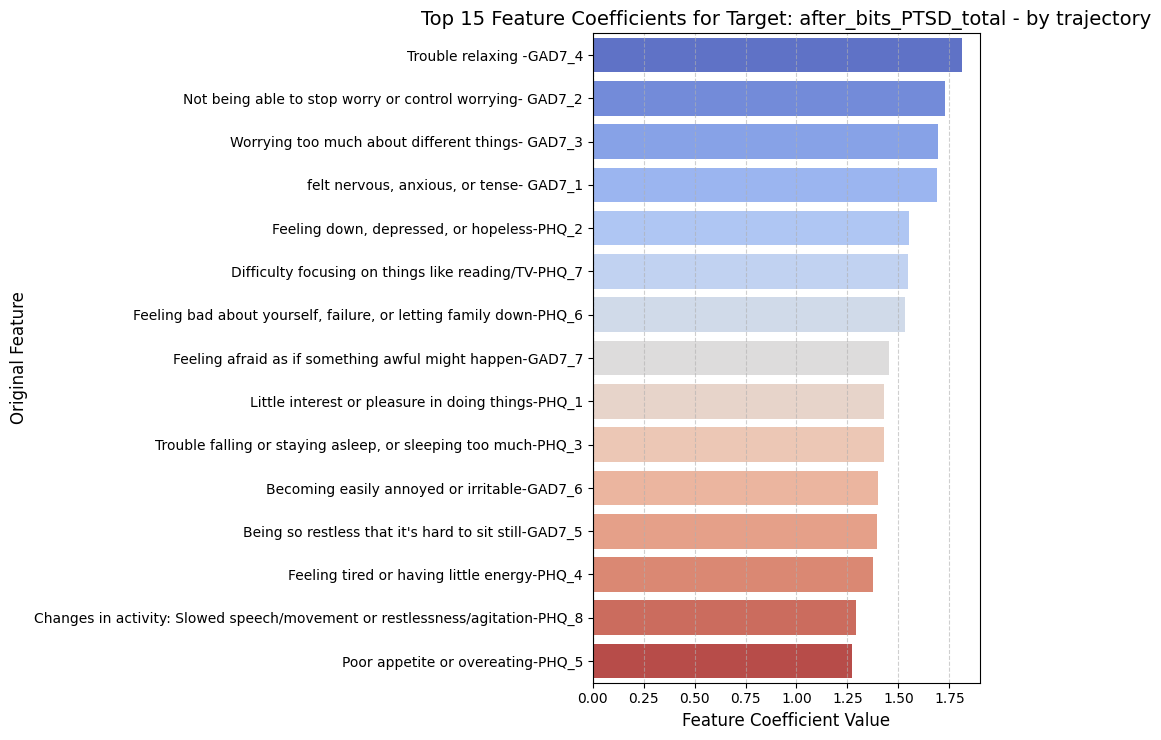

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\21933492.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


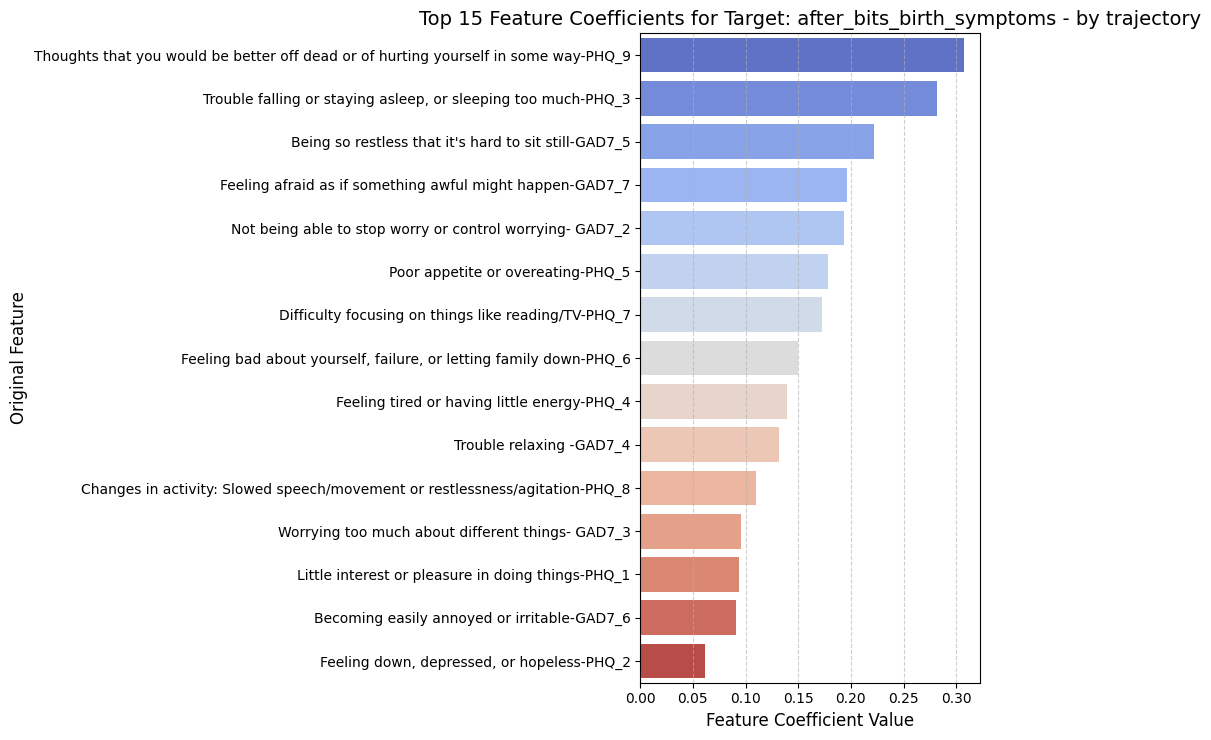

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\21933492.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


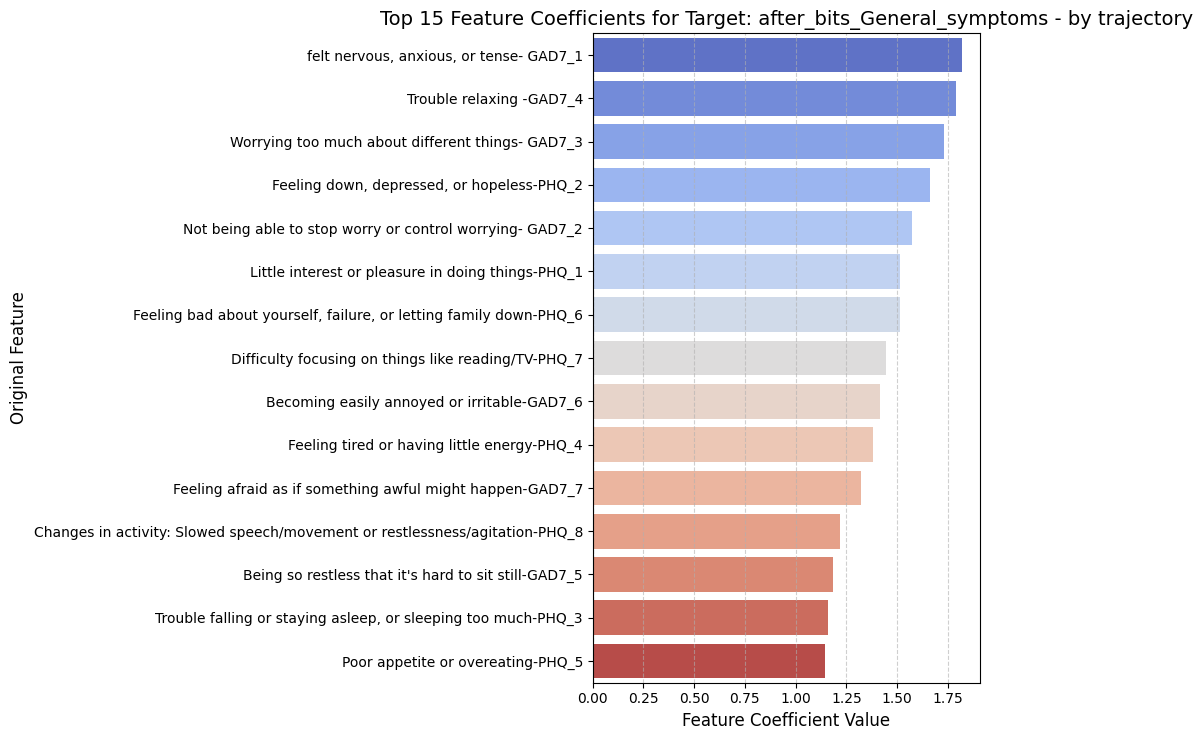

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\21933492.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


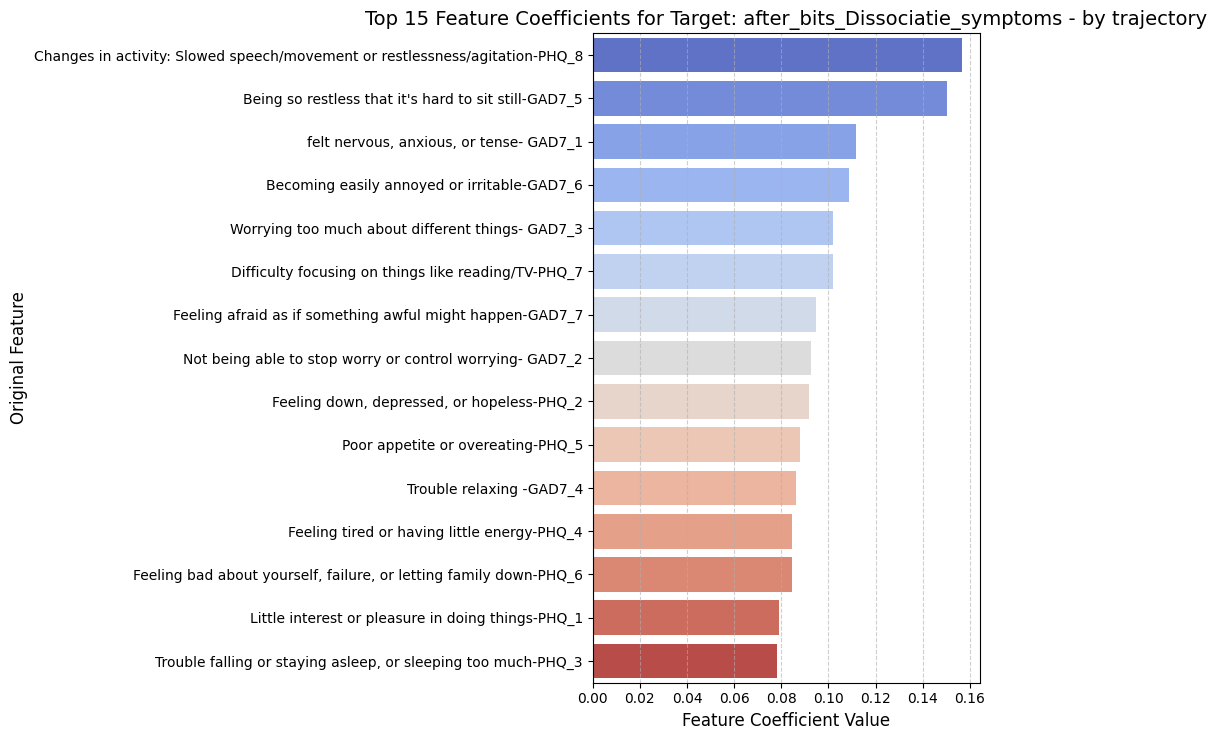


Completed plotting. Individual target plots saved to 'only_Q_outputs\combined\regression\with-pca\plot_outputs_pca_by_target'.


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np

# --- FEATURE MAPPING ---
FEATURE_MAPPING = {
    "GAD7_1": "felt nervous, anxious, or tense- GAD7_1",
    "GAD7_2": "Not being able to stop worry or control worrying- GAD7_2",
    "GAD7_3": "Worrying too much about different things- GAD7_3",
    "GAD7_4": "Trouble relaxing -GAD7_4",
    "GAD7_5": "Being so restless that it's hard to sit still-GAD7_5",
    "GAD7_6": "Becoming easily annoyed or irritable-GAD7_6",
    "GAD7_7": "Feeling afraid as if something awful might happen-GAD7_7",
    "PHQ_1": "Little interest or pleasure in doing things-PHQ_1",
    "PHQ_2": "Feeling down, depressed, or hopeless-PHQ_2",
    "PHQ_3": "Trouble falling or staying asleep, or sleeping too much-PHQ_3",
    "PHQ_4": "Feeling tired or having little energy-PHQ_4",
    "PHQ_5": "Poor appetite or overeating-PHQ_5",
    "PHQ_6": "Feeling bad about yourself, failure, or letting family down-PHQ_6",
    "PHQ_7": "Difficulty focusing on things like reading/TV-PHQ_7",
    "PHQ_8": "Changes in activity: Slowed speech/movement or restlessness/agitation-PHQ_8",
    "PHQ_9": "Thoughts that you would be better off dead or of hurting yourself in some way-PHQ_9",
    "DEFAULT_SENTENCE": "Feature Importance" 
}

# Define the base directory (from previous step's configuration)
OUTPUT_BASE_DIR = r"only_Q_outputs\combined\regression\with-pca" # Assuming PCA path for this function
PLOTTING_OUTPUT_DIR_BY_TARGET = os.path.join(OUTPUT_BASE_DIR, "plot_outputs_pca_by_target")
TARGET_IMPORTANCE_DIR = os.path.join(OUTPUT_BASE_DIR, "pc_backcalculated_importance_normalized")


# ==============================================================================
# UPDATED FUNCTION: Plot Feature Importance with SIGNED COEFFICIENTS
# ==============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np

# --- FEATURE MAPPING ---
# ... (Assuming FEATURE_MAPPING is defined correctly here) ...

# Define the paths (these should be defined in your execution environment)
OUTPUT_BASE_DIR = r"only_Q_outputs\combined\regression\with-pca" # Assuming PCA path for this function
PLOTTING_OUTPUT_DIR_BY_TARGET = os.path.join(OUTPUT_BASE_DIR, "plot_outputs_pca_by_target")
TARGET_IMPORTANCE_DIR = os.path.join(OUTPUT_BASE_DIR, "pc_backcalculated_importance_normalized")


# ==============================================================================
# UPDATED FUNCTION: Plot Feature Importance with SIGNED COEFFICIENTS
# ==============================================================================

def plot_features_by_target(target_list, feature_map, input_dir, output_dir, top_n=15):
    """
    Loads individual target importance CSVs and plots a horizontal bar chart 
    showing the top N original features using the SIGNED COEFFICIENT VALUE.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n--- Generating Feature Coefficient Plots (By Target) ---")
    print(f"Plots saved to: {output_dir}")

    for target in target_list:
        safe_target_name = target.replace(" ", "_").replace("/", "-")
        # Assuming the PCA back-calculated CSV naming convention
        file_path = os.path.join(input_dir, f"{safe_target_name}_feature_importance_pca_backcalculated.csv")
        
        if not os.path.exists(file_path):
            continue

        try:
            df_imp = pd.read_csv(file_path)
            
            # --- MODIFICATION START: Use Signed Value and Calculate Absolute for Sorting ---
            
            # 1. Identify/Create the signed value column
            # We assume 'coefficient' exists, or 'importance' (from the PCA back-calculation) is the raw signed importance.
            if 'coefficient' in df_imp.columns:
                 df_imp['signed_value'] = pd.to_numeric(df_imp['coefficient'], errors='coerce')
            elif 'importance' in df_imp.columns:
                 # If 'importance' is present, we assume it's the signed back-calculated value.
                 df_imp['signed_value'] = pd.to_numeric(df_imp['importance'], errors='coerce')
            else:
                 print(f"❌ Error: Missing required column ('coefficient' or 'importance') in CSV for {target}.")
                 continue
                 
            # 2. Calculate absolute value for filtering and sorting
            df_imp['abs_coefficient'] = df_imp['signed_value'].abs()

            # 3. Filter for non-zero contributions
            df_plot = df_imp[df_imp['abs_coefficient'] != 0].copy()
            
            if df_plot.empty:
                print(f"📉 Skipping target '{target}': No non-zero features found.")
                continue

            # 4. Sort by absolute coefficient (most impactful feature first)
            df_plot = df_plot.sort_values(by='abs_coefficient', ascending=False).head(top_n).copy()
            
            # --- MODIFICATION END ---
            
            # Map feature names to descriptive labels for the y-axis
            df_plot['feature_label'] = df_plot['feature'].apply(
                lambda x: feature_map.get(x, feature_map['DEFAULT_SENTENCE'])
            )
            
            # Calculate figure size
            fig_height = max(5, len(df_plot) * 0.5) 
            plt.figure(figsize=(10, fig_height))

            # Create Horizontal Bar Plot
            sns.barplot(
                data=df_plot,
                x='signed_value', # PLOT THE SIGNED VALUE
                y='feature_label',
                # Using a divergent palette (e.g., 'coolwarm') works best for signed data
                palette='coolwarm' 
            )
            
            # Add vertical line at x=0 to clearly distinguish signs
            plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

            # Update title and labels
            plt.title(f'Top {len(df_plot)} Feature Coefficients for Target: {target} - by trajectory', fontsize=14)
            plt.xlabel('Feature Coefficient Value', fontsize=12)
            plt.ylabel('Original Feature', fontsize=12)
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            
            plt.tight_layout()
            
            # Save the plot
            plot_filename = os.path.join(output_dir, f"{safe_target_name}_signed_coefficient_by_feature.png")
            plt.savefig(plot_filename)
            plt.show()
            plt.close()
            
        except Exception as e:
            print(f"❌ Error plotting target {target}: {e}")

    print(f"\nCompleted plotting. Individual target plots saved to '{output_dir}'.")

# ==============================================================================
# EXECUTION CALL (Example usage, assuming TARGETS are defined)
# ==============================================================================

# TARGETS placeholder for example:
TARGETS = [
    'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
    'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms'
]

# This is the function call to run the plotting:
plot_features_by_target(
    target_list=TARGETS,
    feature_map=FEATURE_MAPPING,
    input_dir=TARGET_IMPORTANCE_DIR,
    output_dir=PLOTTING_OUTPUT_DIR_BY_TARGET,
    top_n=15 
)

✅ Loaded R² values for B from only_Q_outputs\combined\regression\without-pca\regression_feature_importance_b_no_pca.csv.

--- Generating Plots for Time Point: B ---


C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


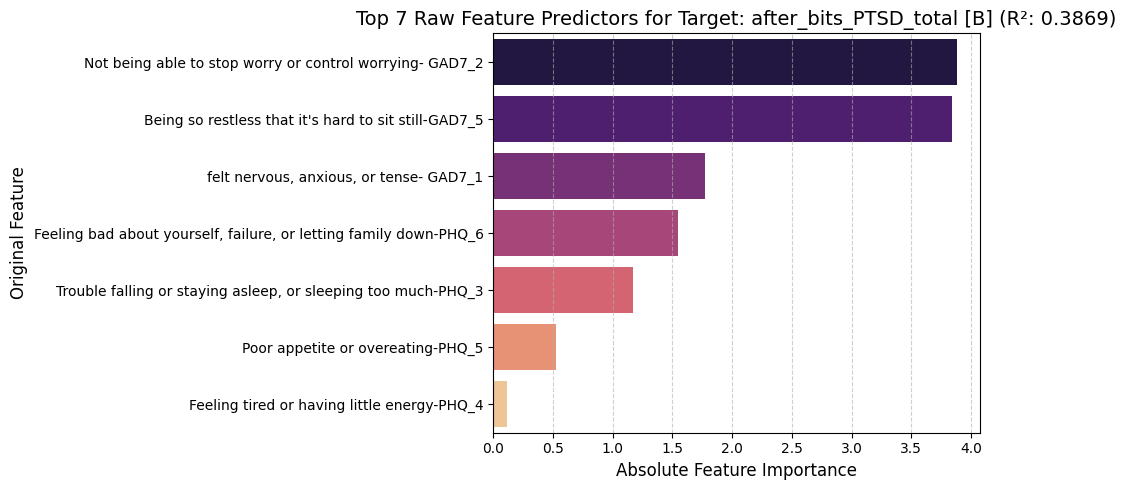

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


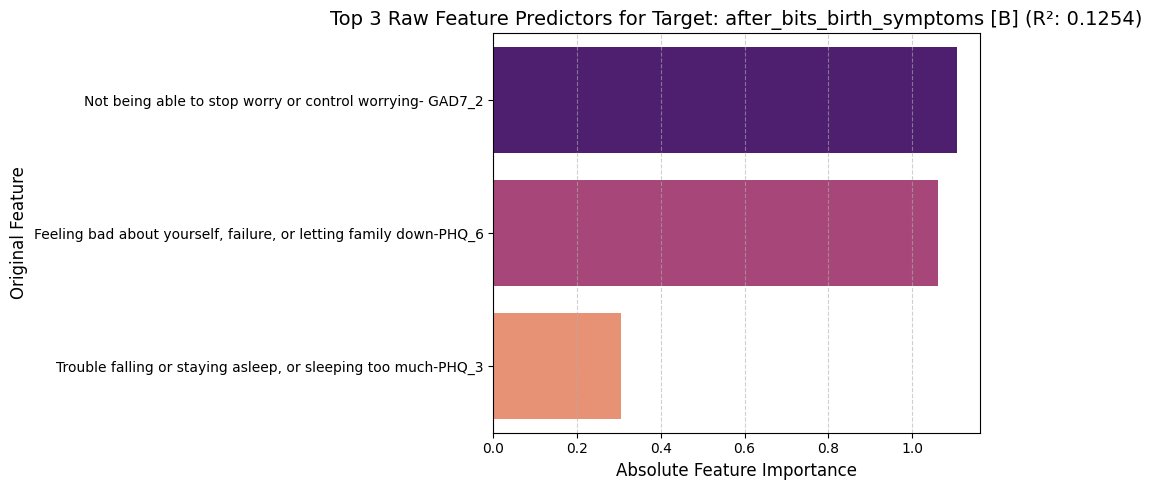

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


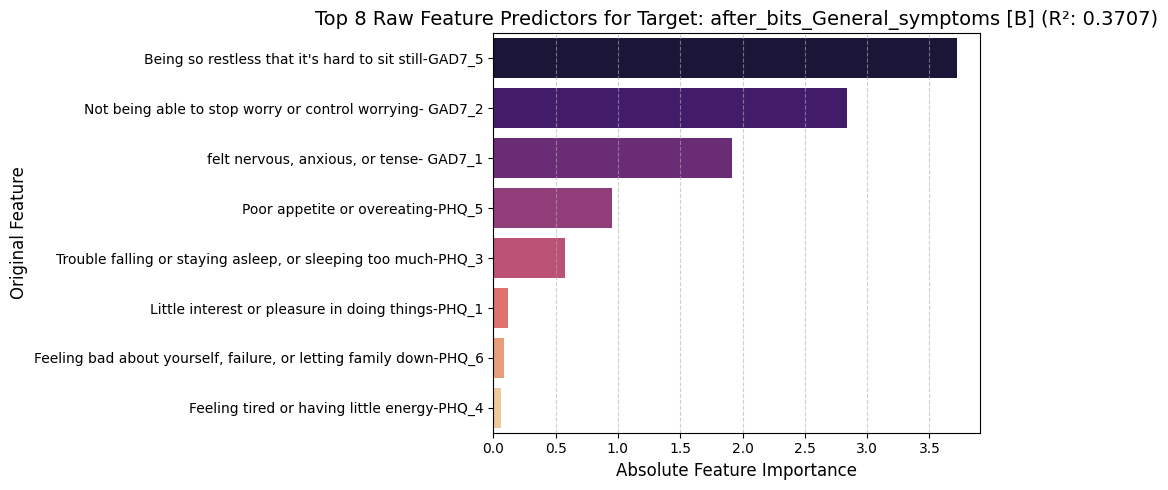

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


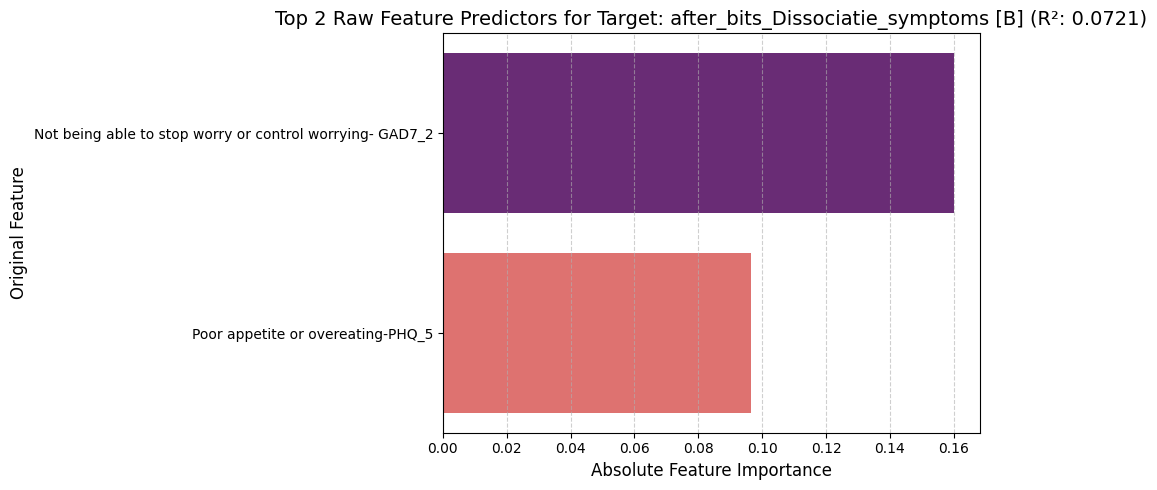

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Completed plotting for time point B.
✅ Loaded R² values for T1 from only_Q_outputs\combined\regression\without-pca\regression_feature_importance_t1_no_pca.csv.

--- Generating Plots for Time Point: T1 ---


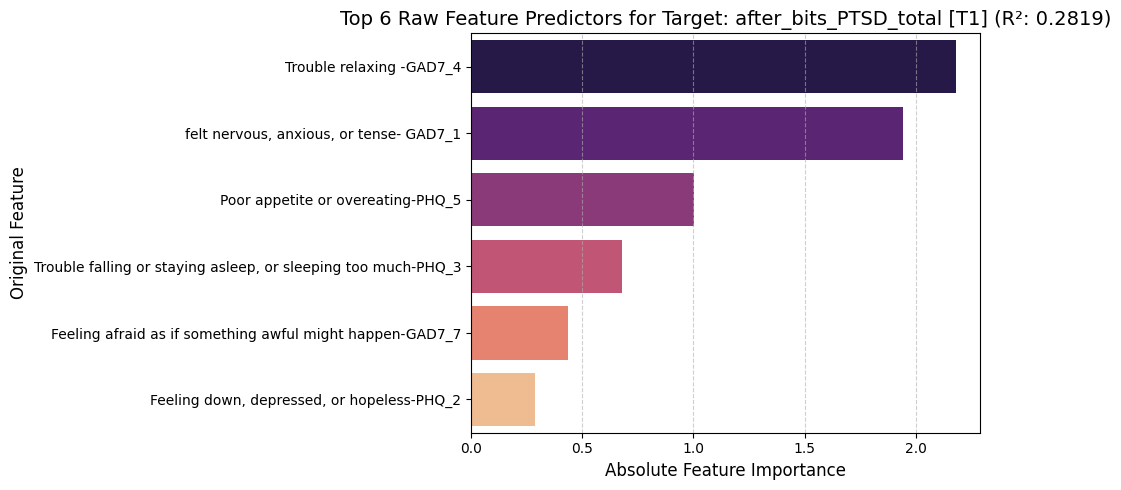

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


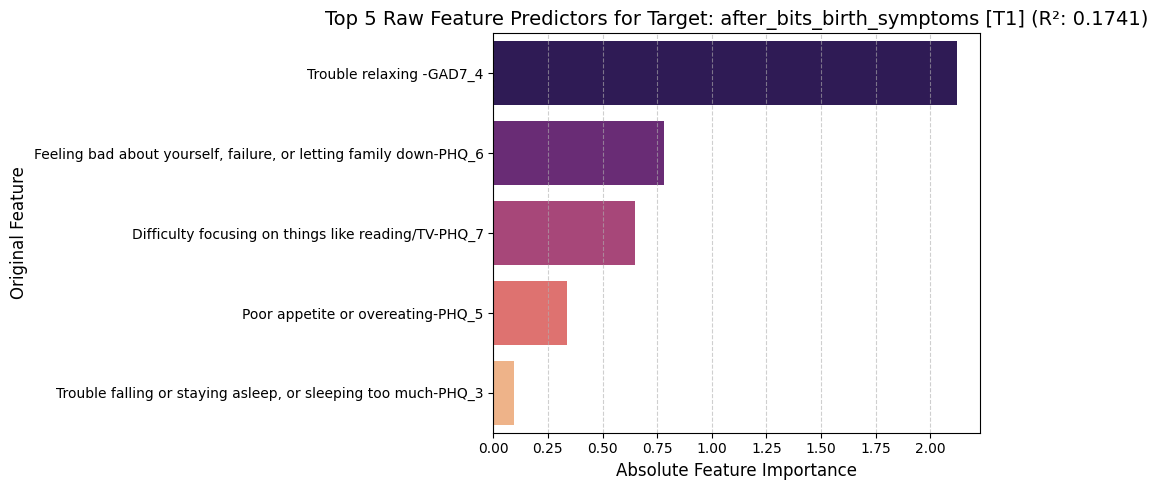

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


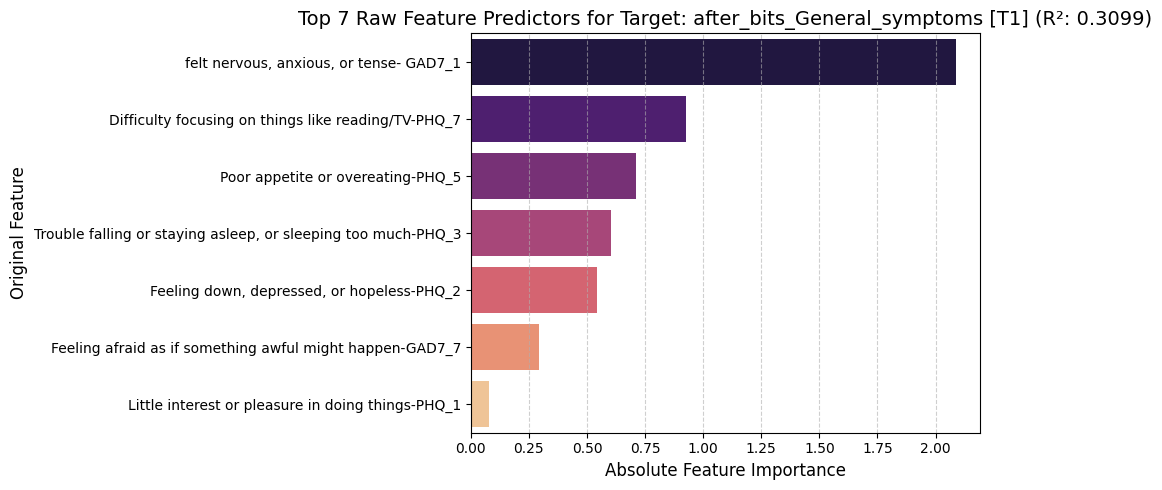

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


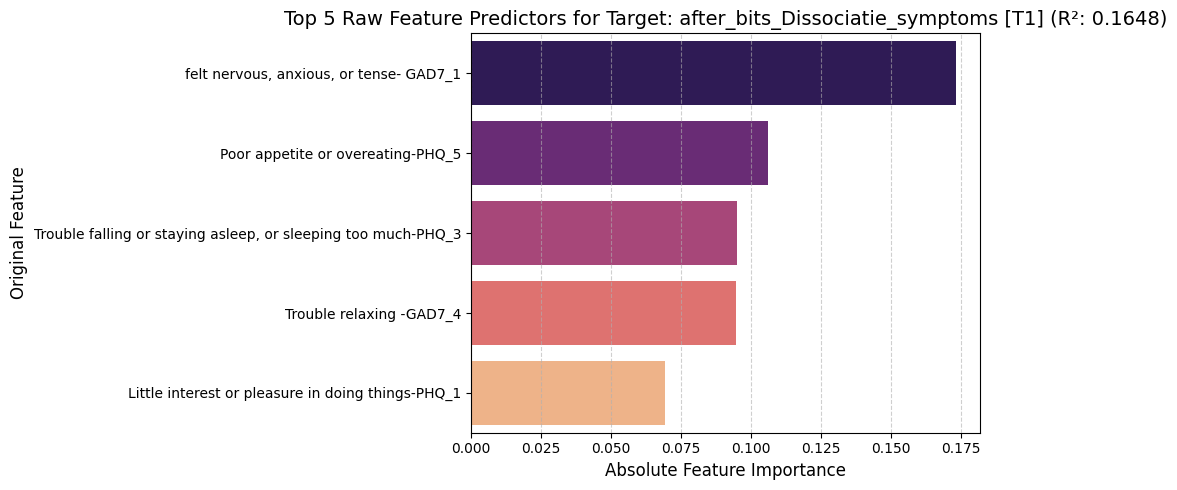

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Completed plotting for time point T1.
✅ Loaded R² values for T2 from only_Q_outputs\combined\regression\without-pca\regression_feature_importance_t2_no_pca.csv.

--- Generating Plots for Time Point: T2 ---


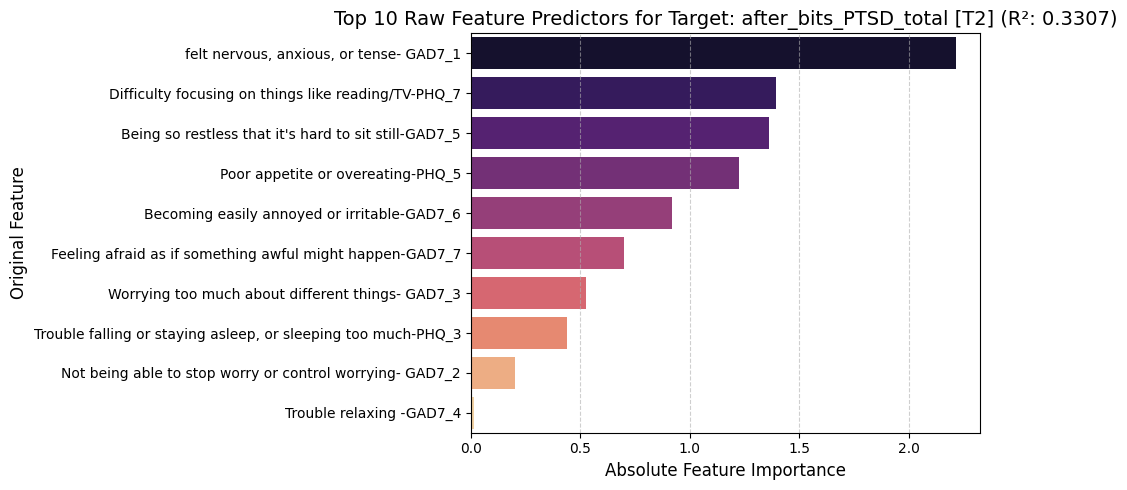

📉 Skipping target 'after_bits_birth_symptoms' at t2: No non-zero features found.


C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


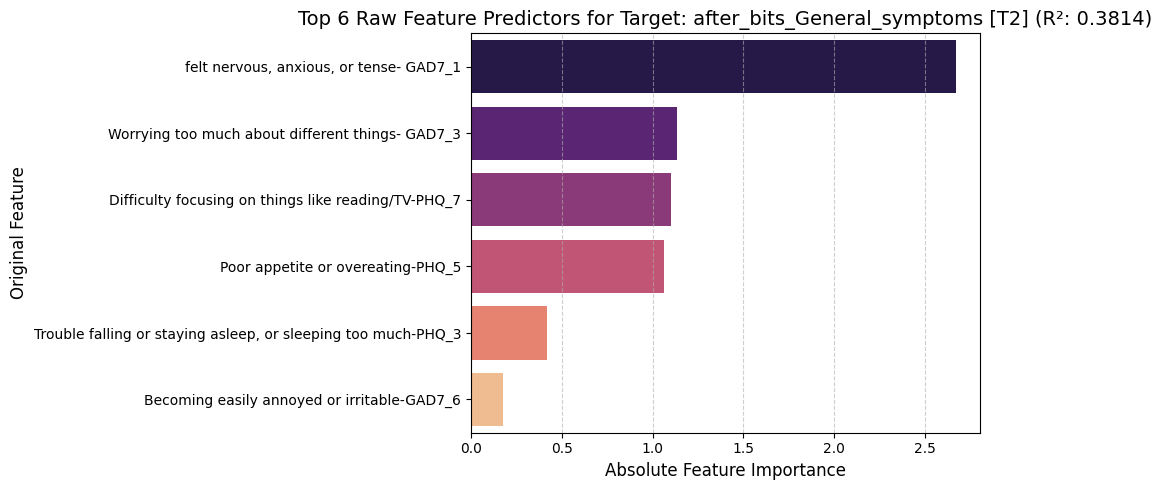

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


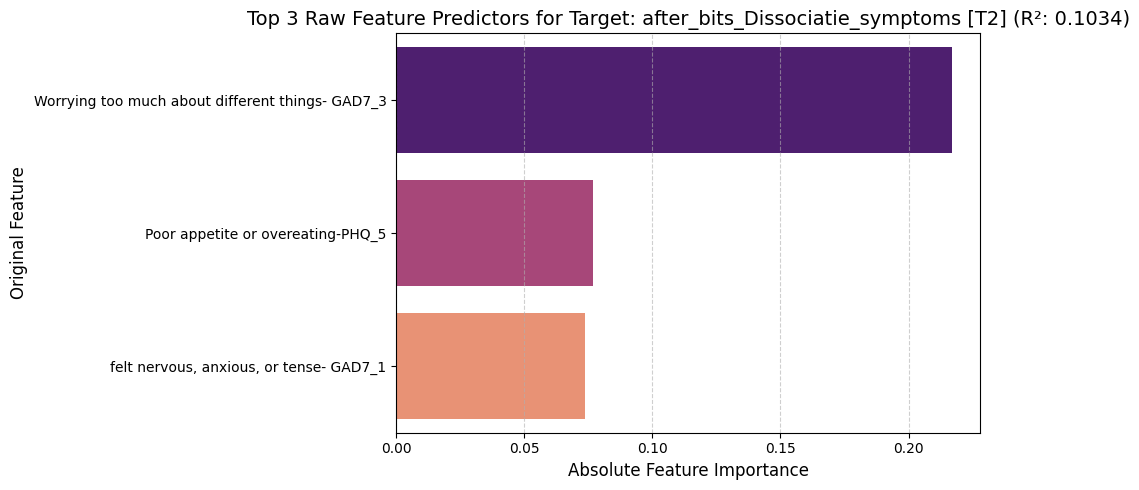

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Completed plotting for time point T2.
✅ Loaded R² values for T3 from only_Q_outputs\combined\regression\without-pca\regression_feature_importance_t3_no_pca.csv.

--- Generating Plots for Time Point: T3 ---


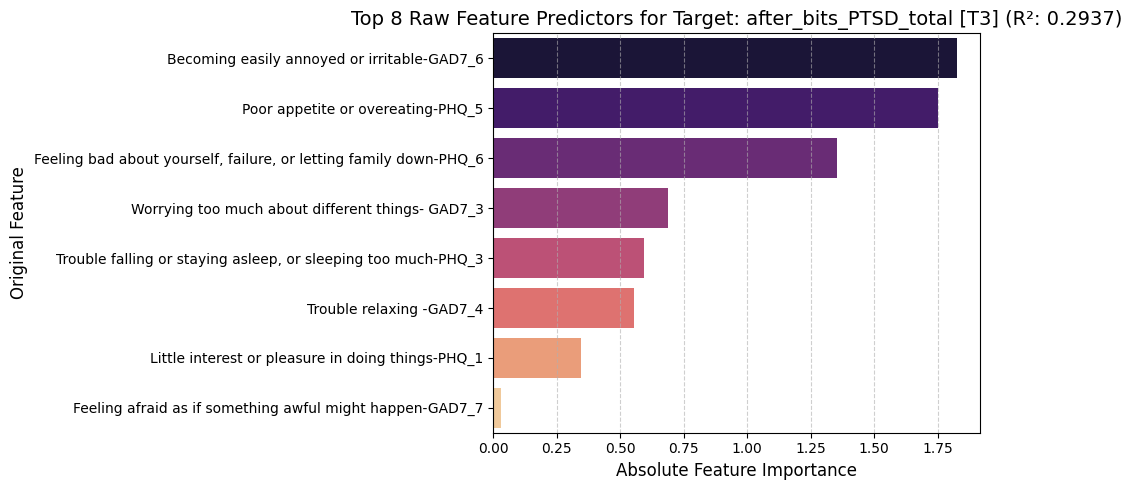

📉 Skipping target 'after_bits_birth_symptoms' at t3: No non-zero features found.


C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


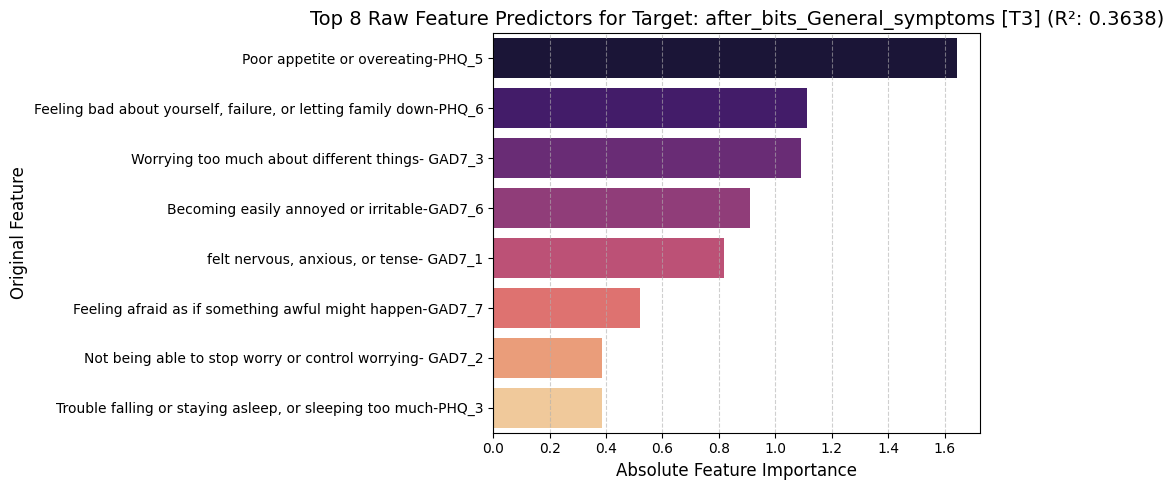

📉 Skipping target 'after_bits_Dissociatie_symptoms' at t3: No non-zero features found.

Completed plotting for time point T3.
✅ Loaded R² values for AFTER from only_Q_outputs\combined\regression\without-pca\regression_feature_importance_after_no_pca.csv.

--- Generating Plots for Time Point: AFTER ---


C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


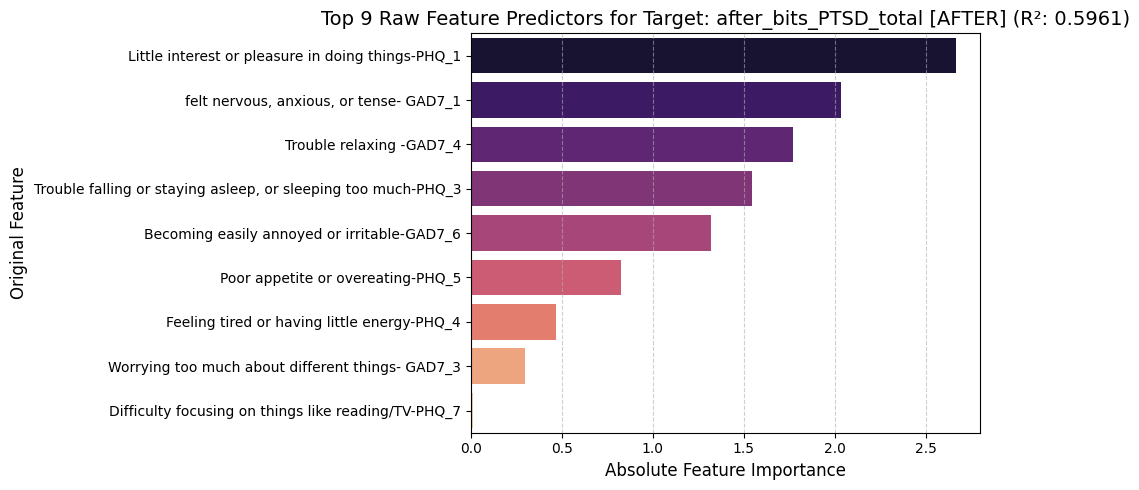

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


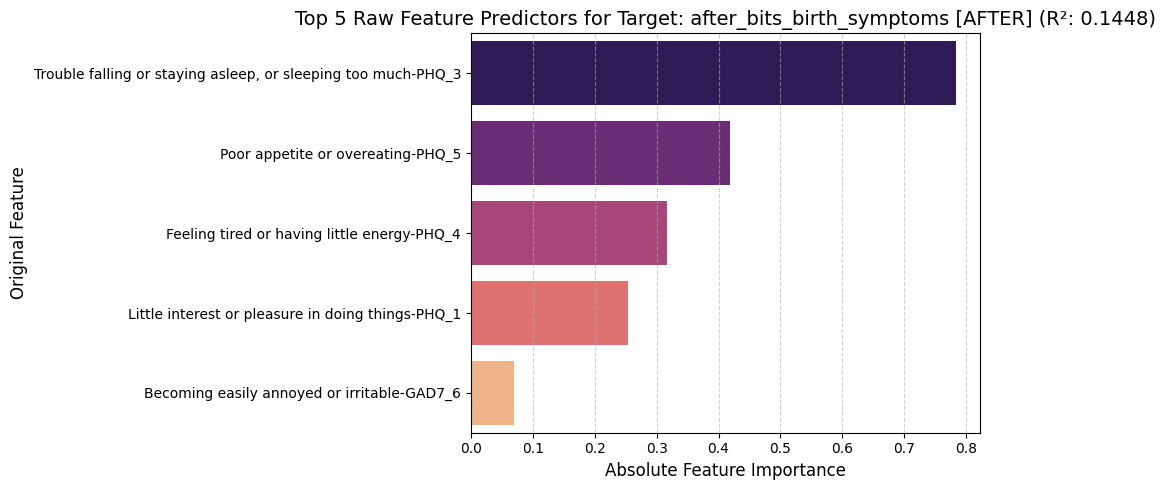

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


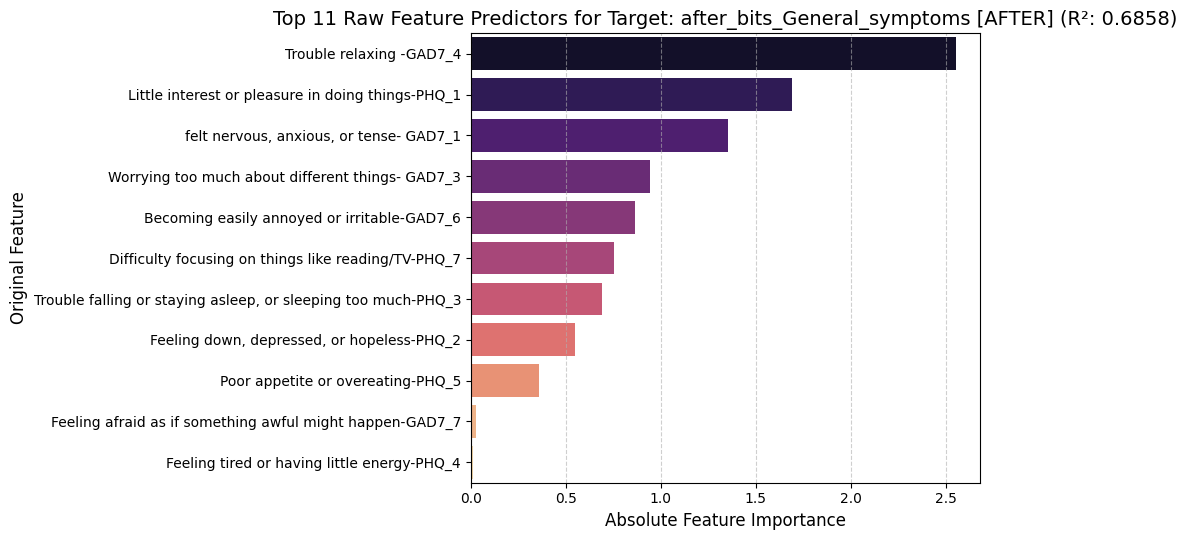

C:\Users\nogag\AppData\Local\Temp\ipykernel_7288\1925522842.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


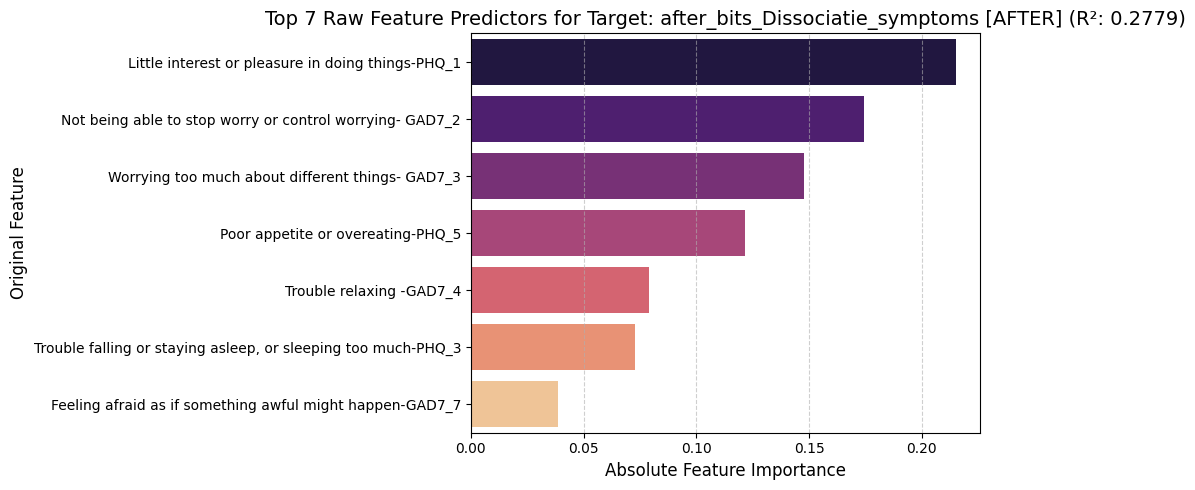


Completed plotting for time point AFTER.

--- All plotting complete ---


In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np

# --- FEATURE MAPPING (Must be defined outside) ---
FEATURE_MAPPING = {
    "GAD7_1": "felt nervous, anxious, or tense- GAD7_1",
    "GAD7_2": "Not being able to stop worry or control worrying- GAD7_2",
    "GAD7_3": "Worrying too much about different things- GAD7_3",
    "GAD7_4": "Trouble relaxing -GAD7_4",
    "GAD7_5": "Being so restless that it's hard to sit still-GAD7_5",
    "GAD7_6": "Becoming easily annoyed or irritable-GAD7_6",
    "GAD7_7": "Feeling afraid as if something awful might happen-GAD7_7",
    "PHQ_1": "Little interest or pleasure in doing things-PHQ_1",
    "PHQ_2": "Feeling down, depressed, or hopeless-PHQ_2",
    "PHQ_3": "Trouble falling or staying asleep, or sleeping too much-PHQ_3",
    "PHQ_4": "Feeling tired or having little energy-PHQ_4",
    "PHQ_5": "Poor appetite or overeating-PHQ_5",
    "PHQ_6": "Feeling bad about yourself, failure, or letting family down-PHQ_6",
    "PHQ_7": "Difficulty focusing on things like reading/TV-PHQ_7",
    "PHQ_8": "Changes in activity: Slowed speech/movement or restlessness/agitation-PHQ_8",
    "PHQ_9": "Thoughts that you would be better off dead or of hurting yourself in some way-PHQ_9",
    "DEFAULT_SENTENCE": "Original Feature" 
}

# --- Define Constants and Paths ---
NON_PCA_BASE_DIR = r"only_Q_outputs\combined\regression\without-pca"
NON_PCA_IMPORTANCE_DIR_BASE = NON_PCA_BASE_DIR # Base directory for summary and feature folders
NON_PCA_PLOTTING_OUTPUT_DIR = os.path.join(NON_PCA_BASE_DIR, "plot_outputs_by_target_non_pca")
NON_PCA_FILE_SUFFIX = "_feature_importance.csv"

# --- Target and Time Point Configuration ---
TARGETS = [
    'after_bits_PTSD_total', 'after_bits_birth_symptoms', 
    'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms'
]
TIMEPOINTS = ['b', 't1', 't2', 't3', 'after']

def get_time_point_folder(tp):
    """Constructs the folder path for feature importance CSVs for a given time point."""
    # Assuming feature folders are named like: 'b_feature_csv', 't1_feature_csv', etc.
    return os.path.join(NON_PCA_BASE_DIR, f"{tp}_feature_csv")

def get_summary_file_path(tp):
    """Constructs the summary CSV path for a given time point."""
    # New file naming convention: regression_feature_importance_[TIMEPOINT]_no_pca.csv
    return os.path.join(NON_PCA_IMPORTANCE_DIR_BASE, f"regression_feature_importance_{tp}_no_pca.csv")


# ==============================================================================
# UPDATED FUNCTION: Plot Feature Importance Separately for Each Target (NON-PCA)
# (Same function definition as before, included for context)
# ==============================================================================
def plot_features_by_target_non_pca(target_list, feature_map, input_dir, output_dir, r2_map, time_label, top_n=15, file_suffix="_feature_importance.csv"):
    """
    Loads individual non-PCA target importance CSVs for a single time point 
    and plots the top N raw features.
    """
    
    print(f"\n--- Generating Plots for Time Point: {time_label.upper()} ---")

    for target in target_list:
        safe_target_name = target.replace(" ", "_").replace("/", "-")
        file_path = os.path.join(input_dir, f"{safe_target_name}{file_suffix}")
        
        r2_value = r2_map.get(target, "N/A")
        r2_label = f" (R²: {r2_value:.4f})" if isinstance(r2_value, (float, np.float64, int)) else f" (R²: {r2_value})"

        if not os.path.exists(file_path):
            continue

        try:
            df_imp = pd.read_csv(file_path)
            
            if 'abs_importance' in df_imp.columns:
                 df_imp = df_imp.rename(columns={'abs_importance': 'importance'})
            elif 'coefficient' in df_imp.columns:
                 df_imp['importance'] = df_imp['coefficient'].abs()

            df_imp['importance'] = pd.to_numeric(df_imp['importance'], errors='coerce')
            df_plot = df_imp[df_imp['importance'] > 1e-6].copy()
            
            if df_plot.empty:
                print(f"📉 Skipping target '{target}' at {time_label}: No non-zero features found.")
                continue

            df_plot = df_plot.sort_values(by='importance', ascending=False).head(top_n).copy()
            
            df_plot['feature_label'] = df_plot['feature'].apply(
                lambda x: feature_map.get(x.split('_', 1)[-1], feature_map['DEFAULT_SENTENCE'])
            )
            
            fig_height = max(5, len(df_plot) * 0.5) 
            plt.figure(figsize=(10, fig_height))

            sns.barplot(
                data=df_plot,
                x='importance',
                y='feature_label',
                palette='magma' 
            )

            plt.title(
                f'Top {len(df_plot)} Raw Feature Predictors for Target: {target} [{time_label.upper()}]{r2_label}', 
                fontsize=14
            )
            
            plt.xlabel('Absolute Feature Importance', fontsize=12)
            plt.ylabel('Original Feature', fontsize=12)
            plt.grid(axis='x', linestyle='--', alpha=0.6)
            
            plt.tight_layout()
            
            plt.show() 
            plt.close()
            
        except Exception as e:
            print(f"❌ Error plotting target {target} at {time_label}: {e}")

    print(f"\nCompleted plotting for time point {time_label.upper()}.")


# ==============================================================================
# EXECUTION SCRIPT (Loops through time points, loads dynamic R2)
# ==============================================================================

# 1. Loop through all time points
for tp in TIMEPOINTS:
    # --- DYNAMICALLY LOAD R2 SUMMARY ---
    current_summary_csv = get_summary_file_path(tp)
    r2_mapping = {}
    
    try:
        summary_df = pd.read_csv(current_summary_csv)
        r2_mapping = summary_df.set_index('target')['R2_cv'].to_dict()
        print(f"✅ Loaded R² values for {tp.upper()} from {current_summary_csv}.")
    except FileNotFoundError:
        print(f"⚠️ WARNING: Summary file not found for {tp.upper()} at {current_summary_csv}. R² will be listed as N/A.")
    except Exception as e:
        print(f"❌ ERROR loading R² summary for {tp.upper()}: {e}. R² will be listed as N/A.")

    # 2. Dynamically set the input directory for the current time point's feature CSVs
    current_input_dir = get_time_point_folder(tp)
    
    # 3. Call the plotting function
    plot_features_by_target_non_pca(
        target_list=TARGETS,
        feature_map=FEATURE_MAPPING,
        input_dir=current_input_dir,
        output_dir=NON_PCA_PLOTTING_OUTPUT_DIR,
        r2_map=r2_mapping, # Pass the dynamically loaded R2 map
        time_label=tp, 
        top_n=15 
    )

print("\n--- All plotting complete ---")